In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os, gc
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [4]:
# train_test = pd.read_csv('data/inter_feat/cat_inter_selected_again_0.csv')
# train_test = reduce_mem_usage_without_print(train_test)

sub_df = pd.read_csv('data/sample_submission.csv')
target_members = pd.read_csv('data/train_target.csv')

train_test.shape, sub_df.shape, target_members.shape

Memory 186.23 MB ==>  42.83 MB
Decreased by 77.0%


((488189, 50), (146765, 2), (341424, 2))

In [5]:
sub_df.head(5)

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,8
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,8
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,8
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,8


In [6]:
target = target_members.target
memberids = target_members.memberids

In [7]:
train_len = 341424
target = target[:train_len]
memberids = memberids[:train_len]


# from sklearn.model_selection import GroupKFold

# group_kfold = GroupKFold(n_splits=2)
# for train_index, test_index in group_kfold.split(train_test.iloc[:train_len], target, memberids):
#     y_tr, y_val    = target[train_index], target[test_index]
#     break
    
from sklearn.model_selection import GroupKFold
group_kfold1 = GroupKFold(n_splits=5)
group_kfold2 = GroupKFold(n_splits=3)
for train_index, test_index in group_kfold1.split(train_test.iloc[:train_len], target, memberids):
    for train_index3, test_index3 in group_kfold2.split(train_test.iloc[test_index], target[test_index], memberids[test_index]):
        break

y_tr, y_val = target[train_index], target[test_index]
y_tr3, y_val3 = target[train_index3], target[test_index3]
        
train_index.shape, test_index.shape, train_index3.shape, test_index3.shape, y_tr.shape, y_val.shape, y_tr3.shape, y_val3.shape

((273140,),
 (68284,),
 (45522,),
 (22762,),
 (273140,),
 (68284,),
 (45522,),
 (22762,))

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, test, features, call_orig=True):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 1,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=200, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)
        print("rmse: ", np.sqrt(score)*100)
        
        pred = clf.predict(test[features], num_iteration=clf.best_iteration)
        
        return clf, oof, pred

    if call_orig:
        # for original dataset
        clf, oof, pred = train_lgb_model(**{
            'b_frac'       : 0.3677516358370858,
            'data_in_leaf' : 495.44417416221626,
            'f_frac'       : 0.5422060360159515,
            'hessian'      : 5.039378213231793,
            'l1'           : 1.0642598045225304,
            'l2'           : 2.564544963055539,
            'leaves'       : 89.62655396835916,
            'split_gain'   : 0.16542750189034394
        })
    else:
    # for categorical ineteraction
        clf, oof, pred = train_lgb_model(**{ 
            'b_frac'       : 0.2728072019276865,
            'data_in_leaf' : 599.1355067878178,
            'f_frac'       : 0.4937418834592164,
            'hessian'      : 6.198622176728424,
            'l1'           : 1.826600484273437,
            'l2'           : 0.1849162529109467,
            'leaves'       : 88.2210088397349,
            'split_gain'   : 0.3879558806359651
        })
    
    return clf, oof, pred

In [9]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_cat(X_train, y_train, X_valid, y_valid, test, features):
    print(X_train.shape)
    def train_cat_model(r_str, b_temp, l2, depth):
    
        params = {}
        params['random_strength']     = max(min(r_str, 1), 0)
        params['bagging_temperature'] = max(b_temp, 0)
        params['l2_leaf_reg'] = max(l2, 0)
        params['depth']     = int(depth)

        param_const = {
            'border_count'          : 63,
            'early_stopping_rounds' : 50,
            'random_seed'           : 1337,
            'task_type'             : 'CPU', 
            'loss_function'         : "RMSE", 
    #         'subsample'             = 0.7, 
            'iterations'            : 10000, 
            'learning_rate'         : 0.01,
            'thread_count'          : 4,
#             'bootstrap_type'        : 'No'
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

        watchlist = [_train, _valid]
        clf = CatBoostRegressor(**params)
        clf.fit(_train, 
                eval_set=watchlist, 
                verbose=500,
                use_best_model=True)

        oof  = clf.predict(X_valid[features])
        score = mean_squared_error(y_valid, oof)
        print("rmse: ", np.sqrt(score)*100)
        
        pred = clf.predict(test[features])
        
        return clf, oof, pred

    clf, oof, pred = train_cat_model(**{
        'b_temp': 0.08307474720468191,
        'depth' : 7.596402546589758,
        'l2'    : 3.9791105400066655,
        'r_str' : 1.1206250787323229
    })
    
    return clf, oof, pred



In [10]:
train_ = train_test.iloc[train_index]
valid_ = train_test.iloc[test_index]
test_df = train_test.iloc[train_len:].reset_index(drop=True)

train_.shape, valid_.shape, test_df.shape

((273140, 50), (68284, 50), (146765, 50))

In [11]:
clf1, oof1, pred1 = bayesian_opt_lgb(train_, y_tr, valid_, y_val, test_df, train_.columns, call_orig=False)

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.990314	valid_1's rmse: 0.997297
[400]	training's rmse: 0.971192	valid_1's rmse: 0.982318
[600]	training's rmse: 0.96205	valid_1's rmse: 0.977591
[800]	training's rmse: 0.955691	valid_1's rmse: 0.975603
[1000]	training's rmse: 0.950534	valid_1's rmse: 0.97466
[1200]	training's rmse: 0.946083	valid_1's rmse: 0.974158
[1400]	training's rmse: 0.942014	valid_1's rmse: 0.973901
[1600]	training's rmse: 0.938182	valid_1's rmse: 0.973709
Early stopping, best iteration is:
[1675]	training's rmse: 0.936732	valid_1's rmse: 0.973647
rmse:  97.36469825204482


In [11]:
train_test2 = pd.read_csv('data/train_test.csv')

cols_to_drop= ['res_staResidence_median','tr_flag','reservationstatusid_code',
               'res_resortType_median','res_stResort_median','res_cluster_median']
train_test2.drop(cols_to_drop, axis=1, inplace=True)

for col in train_test2.columns:
    if col != 'amount_spent_per_room_night_scaled':
        train_test2[col] = train_test2[col].astype('category').cat.codes
        
train_test2.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)


In [21]:
train_test2.drop(['booking_date','checkin_date','checkout_date','memberid'], axis=1, inplace=True)


In [22]:
train_2 = train_test2.iloc[train_index]
valid_2 = train_test2.iloc[test_index]
test_df2 = train_test2.iloc[train_len:].reset_index(drop=True)

train_2.shape, valid_2.shape, test_df2.shape
# ((170712, 55), (170712, 55), (146765, 55))

((273140, 51), (68284, 51), (146765, 51))

In [23]:
clf2, oof2, pred2 = bayesian_opt_lgb(train_2, y_tr, valid_2, y_val, test_df2, train_2.columns)
# rmse:  97.13767154891508

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.988345	valid_1's rmse: 0.994271
[400]	training's rmse: 0.970342	valid_1's rmse: 0.97956
[600]	training's rmse: 0.962279	valid_1's rmse: 0.974888
[800]	training's rmse: 0.956662	valid_1's rmse: 0.972808
[1000]	training's rmse: 0.95216	valid_1's rmse: 0.97185
[1200]	training's rmse: 0.948386	valid_1's rmse: 0.971337
[1400]	training's rmse: 0.945081	valid_1's rmse: 0.971066
[1600]	training's rmse: 0.942006	valid_1's rmse: 0.97086
Early stopping, best iteration is:
[1646]	training's rmse: 0.941315	valid_1's rmse: 0.970813
rmse:  97.08126799006646


In [15]:
clf3, oof3, pred3 = bayesian_opt_cat(train_, y_tr, valid_, y_val, test_df, train_.columns)
# rmse:  97.66653823604247

(273140, 50)
0:	learn: 7.7214869	test: 7.7214869	test1: 7.7190192	best: 7.7190192 (0)	total: 108ms	remaining: 17m 58s
500:	learn: 0.9925986	test: 0.9925986	test1: 0.9962179	best: 0.9962179 (500)	total: 34.7s	remaining: 10m 57s
1000:	learn: 0.9780087	test: 0.9780087	test1: 0.9835937	best: 0.9835937 (1000)	total: 1m 7s	remaining: 10m 5s
1500:	learn: 0.9717186	test: 0.9717186	test1: 0.9794964	best: 0.9794964 (1500)	total: 1m 37s	remaining: 9m 14s
2000:	learn: 0.9666787	test: 0.9666787	test1: 0.9772692	best: 0.9772692 (2000)	total: 2m 12s	remaining: 8m 47s
2500:	learn: 0.9626225	test: 0.9626225	test1: 0.9761445	best: 0.9761442 (2499)	total: 2m 42s	remaining: 8m 6s
3000:	learn: 0.9588311	test: 0.9588311	test1: 0.9754048	best: 0.9754030 (2999)	total: 3m 14s	remaining: 7m 32s
3500:	learn: 0.9552766	test: 0.9552766	test1: 0.9748863	best: 0.9748852 (3495)	total: 3m 48s	remaining: 7m 4s
4000:	learn: 0.9519188	test: 0.9519188	test1: 0.9745367	best: 0.9745367 (4000)	total: 4m 21s	remaining: 6m 31s

In [24]:
clf4, oof4, pred4 = bayesian_opt_cat(train_2, y_tr, valid_2, y_val, test_df2, train_2.columns)
# rmse:  97.15414801160718

(273140, 51)
0:	learn: 7.7214506	test: 7.7214506	test1: 7.7189739	best: 7.7189739 (0)	total: 46.3ms	remaining: 7m 42s
500:	learn: 0.9885434	test: 0.9885434	test1: 0.9918301	best: 0.9918301 (500)	total: 25.1s	remaining: 7m 56s
1000:	learn: 0.9743752	test: 0.9743752	test1: 0.9792908	best: 0.9792908 (1000)	total: 49.5s	remaining: 7m 25s
1500:	learn: 0.9688389	test: 0.9688389	test1: 0.9757151	best: 0.9757151 (1500)	total: 1m 13s	remaining: 6m 57s
2000:	learn: 0.9647190	test: 0.9647190	test1: 0.9739847	best: 0.9739847 (2000)	total: 1m 41s	remaining: 6m 45s
2500:	learn: 0.9613969	test: 0.9613969	test1: 0.9730538	best: 0.9730517 (2498)	total: 2m 12s	remaining: 6m 38s
3000:	learn: 0.9582644	test: 0.9582644	test1: 0.9723649	best: 0.9723649 (3000)	total: 2m 44s	remaining: 6m 24s
3500:	learn: 0.9554463	test: 0.9554463	test1: 0.9718881	best: 0.9718881 (3500)	total: 3m 17s	remaining: 6m 6s
4000:	learn: 0.9527336	test: 0.9527336	test1: 0.9715538	best: 0.9715538 (4000)	total: 3m 49s	remaining: 5m 43s

In [17]:
gc.collect()

831

In [28]:
# train_len = 341424
# target = target[:train_len]
# memberids = memberids[:train_len]

# from sklearn.model_selection import GroupKFold
# group_kfold1 = GroupKFold(n_splits=2)
# group_kfold2 = GroupKFold(n_splits=3)
# for train_index2, test_index2 in group_kfold1.split(train_test.iloc[:train_len], target, memberids):
#     for train_index3, test_index3 in group_kfold2.split(train_test.iloc[test_index2], target[test_index2], memberids[test_index2]):

#         y_tr3, y_val3    = target[train_index3], target[test_index3]
#         break

# train_index3.shape, test_index3.shape, y_tr3.shape, y_val3.shape

((113808,), (56904,), (113808,), (56904,))

In [44]:
pred_all = np.column_stack([pred1, pred2, pred3, pred4])
oof_all  = np.column_stack([oof1, oof2, oof3, oof4])


In [46]:
mean_squared_error(oof_all.mean(axis=1), y_val)


0.9451688365646018

In [49]:
train_oof = oof_all.mean(axis=1)[train_index3]
valid_oof = oof_all.mean(axis=1)[test_index3]

train_oof.shape, valid_oof.shape, y_tr3.shape, y_val3.shape

((113808,), (56904,), (113808,), (56904,))

In [48]:
oof_all.mean(axis=1)[train_index3]#, y_val

# train_, valid_, y_tr, y_val

array([8.42190432, 7.65546193, 8.20213201, ..., 8.12747676, 7.91075654,
       7.52199987])

In [53]:
train_oof = train_oof.reshape(-1,1)
valid_oof = valid_oof.reshape(-1,1)
train_oof.shape, valid_oof.shape, y_tr3.shape, y_val3.shape

((113808, 1), (56904, 1), (113808,), (56904,))

bayesian ridge ==================================================
100%|██████████| 25/25 [00:00<00:00, 82.94it/s, best loss: 1.1504080860958164]
{'alpha1': 2.2355246116841445, 'alpha2': 3.475120859161531, 'lambda1': 2.8006046056645264, 'lambda2': 0.6019080103763894}
lasso ==================================================
100%|██████████| 25/25 [00:00<00:00, 177.72it/s, best loss: 1.1504094402474907]
{'alpha': 419.51325861935135}
elastic_net ==================================================
100%|██████████| 25/25 [00:00<00:00, 217.48it/s, best loss: 1.1504094402474907]
{'alpha': 533.4683687235575}
ridge ==================================================
100%|██████████| 25/25 [00:00<00:00, 193.47it/s, best loss: 1.150408186977832] 
{'alpha': 6.942366317134041}


In [18]:
train_test3 = train_test2.copy()

new_cols = []
print("Shape: ", train_test3.shape, " ==> ", end=" ")

gps = train_test3.groupby(['checkin_date', 'resort_id'])['roomnights'].aggregate(['median','count'])
gps.columns = ['checkin_resort_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['checkin_date','resort_id'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['checkin_date', 'resort_type_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['checkin_resortType_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['checkin_date','resort_type_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['checkin_date', 'resort_region_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['checkin_resortRegion_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['checkin_date','resort_region_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['checkin_date', 'days_diff'])['roomnights'].aggregate(['median','count'])
gps.columns = ['checkin_daysDiff_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['checkin_date','days_diff'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['checkin_date', 'cluster_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['checkin_cluster_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['checkin_date','cluster_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['booking_date', 'resort_id'])['roomnights'].aggregate(['median','count'])
gps.columns = ['booking_resort_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['booking_date','resort_id'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['booking_date', 'resort_type_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['booking_resortType_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['booking_date','resort_type_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['booking_date', 'resort_region_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['booking_resortRegion_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['booking_date','resort_region_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['booking_date', 'days_diff'])['roomnights'].aggregate(['median','count'])
gps.columns = ['booking_daysDiff_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['booking_date','days_diff'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['booking_date', 'cluster_code'])['roomnights'].aggregate(['median','count'])
gps.columns = ['booking_cluster_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['booking_date','cluster_code'], how='left')
new_cols = new_cols + list(gps.columns)

gps = train_test3.groupby(['memberid'])['roomnights'].aggregate(['median','count'])
gps.columns = ['mem_'+col for col in gps.columns]
train_test3 = pd.merge(train_test3, gps, on=['memberid'], how='left')
new_cols = new_cols + list(gps.columns)

print(train_test3.shape)

for col in train_test3.columns:
    if col != 'amount_spent_per_room_night_scaled':
        train_test3[col] = train_test3[col].astype('category').cat.codes
        

Shape:  (488189, 55)  ==>  (488189, 77)


In [ ]:

# train_len = 341424

# train_df = train_test.iloc[:train_len]
# test_df  = train_test.iloc[train_len:]
# test_df = test_df.reset_index(drop=True)

# # target = train_df['amount_spent_per_room_night_scaled']

# # train_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)
# # test_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)

# print(train_df.shape, test_df.shape, target.shape)

# print("Shape: ", train_df.shape)#, " ==> ", end=" ")

# # train_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)
# # test_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)

# # print(train_df.shape)


In [19]:
train_3 = train_test3.iloc[train_index]
valid_3 = train_test3.iloc[test_index]
test_df3 = train_test3.iloc[train_len:].reset_index(drop=True)

train_3.shape, valid_3.shape, test_df3.shape
# ((170712, 55), (170712, 55), (146765, 55))

((273140, 77), (68284, 77), (146765, 77))

In [20]:
clf5, oof5, pred5 = bayesian_opt_lgb(train_3, y_tr, valid_3, y_val, test_df3, train_3.columns)
# rmse:  97.37362351702502

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.987786	valid_1's rmse: 0.994031
[400]	training's rmse: 0.969231	valid_1's rmse: 0.979547
[600]	training's rmse: 0.960385	valid_1's rmse: 0.974971
[800]	training's rmse: 0.953971	valid_1's rmse: 0.972966
[1000]	training's rmse: 0.948573	valid_1's rmse: 0.971988
[1200]	training's rmse: 0.94388	valid_1's rmse: 0.971494
[1400]	training's rmse: 0.93964	valid_1's rmse: 0.971222
[1600]	training's rmse: 0.935755	valid_1's rmse: 0.971029
Early stopping, best iteration is:
[1580]	training's rmse: 0.936135	valid_1's rmse: 0.971024
rmse:  97.10239493830304


In [21]:
clf6, oof6, pred6 = bayesian_opt_cat(train_3, y_tr, valid_3, y_val, test_df3, train_3.columns)
# rmse:  97.3993952673854

(273140, 77)
0:	learn: 7.7214591	test: 7.7214591	test1: 7.7189855	best: 7.7189855 (0)	total: 100ms	remaining: 16m 39s
500:	learn: 0.9892063	test: 0.9892063	test1: 0.9924181	best: 0.9924181 (500)	total: 37.6s	remaining: 11m 53s
1000:	learn: 0.9745877	test: 0.9745877	test1: 0.9795137	best: 0.9795137 (1000)	total: 1m 15s	remaining: 11m 19s
1500:	learn: 0.9688939	test: 0.9688939	test1: 0.9759941	best: 0.9759941 (1500)	total: 1m 51s	remaining: 10m 31s
2000:	learn: 0.9646665	test: 0.9646665	test1: 0.9742580	best: 0.9742580 (2000)	total: 2m 27s	remaining: 9m 49s
2500:	learn: 0.9610479	test: 0.9610479	test1: 0.9733625	best: 0.9733625 (2500)	total: 3m 2s	remaining: 9m 8s
3000:	learn: 0.9577802	test: 0.9577802	test1: 0.9727104	best: 0.9727104 (3000)	total: 3m 38s	remaining: 8m 30s
3500:	learn: 0.9546951	test: 0.9546951	test1: 0.9722623	best: 0.9722623 (3500)	total: 4m 15s	remaining: 7m 53s
4000:	learn: 0.9517991	test: 0.9517991	test1: 0.9719453	best: 0.9719452 (3997)	total: 4m 50s	remaining: 7m 

In [26]:
len(set(train_4.columns))

127

In [25]:
train_4 = pd.concat([train_3, train_], axis=1)
valid_4 = pd.concat([valid_3, valid_], axis=1)
test_df4 = pd.concat([test_df3, test_df], axis=1)

train_4.shape, valid_4.shape, test_df4.shape

((273140, 127), (68284, 127), (146765, 127))

In [27]:
clf7, oof7, pred7 = bayesian_opt_lgb(train_4, y_tr, valid_4, y_val, test_df4, train_4.columns)
# rmse:  97.4324204814029

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.98498	valid_1's rmse: 0.992529
[400]	training's rmse: 0.966369	valid_1's rmse: 0.978807
[600]	training's rmse: 0.95693	valid_1's rmse: 0.974656
[800]	training's rmse: 0.949888	valid_1's rmse: 0.972963
[1000]	training's rmse: 0.943939	valid_1's rmse: 0.972079
[1200]	training's rmse: 0.93875	valid_1's rmse: 0.971724
[1400]	training's rmse: 0.933887	valid_1's rmse: 0.971563
Early stopping, best iteration is:
[1384]	training's rmse: 0.934259	valid_1's rmse: 0.971551
rmse:  97.15513232612538


In [28]:
clf8, oof8, pred8 = bayesian_opt_cat(train_4, y_tr, valid_4, y_val, test_df4, train_4.columns)
# rmse:  97.38982404733983

(273140, 127)
0:	learn: 7.7214757	test: 7.7214757	test1: 7.7190198	best: 7.7190198 (0)	total: 97ms	remaining: 16m 9s
500:	learn: 0.9883961	test: 0.9883961	test1: 0.9916605	best: 0.9916605 (500)	total: 45.9s	remaining: 14m 29s
1000:	learn: 0.9740420	test: 0.9740420	test1: 0.9792088	best: 0.9792088 (1000)	total: 1m 28s	remaining: 13m 11s
1500:	learn: 0.9680685	test: 0.9680685	test1: 0.9756946	best: 0.9756946 (1500)	total: 2m 6s	remaining: 11m 54s
2000:	learn: 0.9634032	test: 0.9634032	test1: 0.9740119	best: 0.9740119 (2000)	total: 2m 44s	remaining: 10m 56s
2500:	learn: 0.9595087	test: 0.9595087	test1: 0.9731488	best: 0.9731477 (2499)	total: 3m 20s	remaining: 10m
3000:	learn: 0.9559620	test: 0.9559620	test1: 0.9726084	best: 0.9726084 (3000)	total: 3m 57s	remaining: 9m 14s
3500:	learn: 0.9526663	test: 0.9526663	test1: 0.9722377	best: 0.9722374 (3499)	total: 4m 37s	remaining: 8m 34s
4000:	learn: 0.9494705	test: 0.9494705	test1: 0.9719620	best: 0.9719614 (3996)	total: 5m 13s	remaining: 7m 50

In [36]:
del train_test, train_test2, train_test3
gc.collect()

6486

In [95]:
gc.collect()

107

In [25]:
from sklearn.decomposition import TruncatedSVD
def get_svd_cat_wise(train, test=None, n_components=1, col_name=None):
    """return svd transformation
    Args:
        train, test: dataframe
        col_name: list of column name to be transform [if None, used all column]
        n_component: no of component to be used
    example:
        train_svd, test_svd, svd = svd_decomposition(X.iloc[:10], X.iloc[10:15], 2)
    """
    if col_name is None:
        col_name = train.columns

    if test is None:
        complete_df = train[col_name]
    else:
        complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    
    complete_svd = pd.DataFrame()
    for col in col_name:
        svd = TruncatedSVD(n_components=n_components)
        
        if(len(np.unique(complete_df[col])) > 200):
            print("please take care of ",col, ". It will raise memory error!")
        tp__ = pd.get_dummies(complete_df[col])
#         print( "==", tp__.shape)
        tp = svd.fit_transform(tp__)
        tp = pd.DataFrame(data=tp)
        tp.columns = [col+'_'+str(i) for i in range(n_components)]
        complete_svd = pd.concat([complete_svd, tp], axis=1)
        print("|", end="")
#     complete_svd = pd.DataFrame(data=complete_svd)
#     complete_svd.columns = [col_name[j]+'_'+str(i)+'_'+str(j) for i in range(n_components) for j in range(len(col_name))]

    if test is None:
        train_svd = complete_svd
    else:
        train_svd = complete_svd.iloc[:train.shape[0]]
        test_svd = complete_svd.iloc[train.shape[0]:].reset_index(drop=True)

    del complete_svd, complete_df
    gc.collect()
    
    if test is None:
        return train_svd
    else:
        return train_svd, test_svd

In [17]:
def get_count(df):
    return df.apply(lambda x: pd.Series.value_counts(x).shape[0], axis=0)


In [20]:
get_count(train_test)

booking_type_code                  2
channel_code                       3
cluster_code                       6
main_product_code                  5
member_age_buckets                10
memberid                      144823
numberofadults                     9
numberofchildren                  13
persontravellingid                 6
resort_id                         32
resort_region_code                 3
resort_type_code                   7
room_type_booked_code              6
roomnights                        48
season_holidayed_code              5
state_code_residence              38
state_code_resort                 11
total_pax                          8
days_diff                          8
booking_week                      53
booking_month                     12
booking_year                       6
booking_dow                        7
checkin_week                      53
checkin_month                     12
checkin_year                       6
checkin_dow                        7
m

In [18]:
# train_test = pd.concat([train_2, valid_2, test_df2], axis=0)
# train_test.shape

(488189, 52)

In [ ]:
# train_test.drop(['booking_date','checkin_date','checkout_date','memberid'], axis=1, inplace=True)

In [26]:
train_test3 = get_svd_cat_wise(train_test2, n_components=1)
train_test3.shape

||||||||||||||||||||||||||||||||||||||please take care of  res_staResidence_count . It will raise memory error!
|||||||||||||

(488189, 51)

In [27]:
train_3 = train_test3.iloc[train_index]
valid_3 = train_test3.iloc[test_index]
test_df3 = train_test3.iloc[train_len:].reset_index(drop=True)

train_3.shape, valid_3.shape, test_df3.shape

((273140, 51), (68284, 51), (146765, 51))

In [113]:
train_3 = train_test.iloc[:train_2.shape[0]]
valid_3  = train_test.iloc[train_2.shape[0]:train_2.shape[0]+valid_2.shape[0]]
test_df3 = train_test.iloc[-test_df.shape[0]:].reset_index(drop=True)

train_3.shape, valid_3.shape, test_df3.shape

((273140, 51), (68284, 51), (146765, 51))

In [ ]:
clf9, oof9, pred9 = bayesian_opt_lgb(train_3, y_tr, valid_3, y_val, test_df3, train_3.columns)
# 97.3720663599462

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.993946	valid_1's rmse: 0.999189
[400]	training's rmse: 0.975155	valid_1's rmse: 0.983857
[600]	training's rmse: 0.966475	valid_1's rmse: 0.978943
[800]	training's rmse: 0.960361	valid_1's rmse: 0.97688
[1000]	training's rmse: 0.95527	valid_1's rmse: 0.975665
[1200]	training's rmse: 0.950709	valid_1's rmse: 0.974903


In [ ]:
clf10, oof10, pred10 = bayesian_opt_cat(train_3, y_tr, valid_3, y_val, test_df3, train_3.columns)
# 97.45961905149959

In [126]:
# pred_all = np.column_stack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8])
# oof_all  = np.column_stack([oof1, oof2, oof3, oof4, oof5, oof6, oof7, oof8])

# pred_all = pd.DataFrame(data=pred_all, columns=['pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8'])
# oof_all = pd.DataFrame(data=oof_all, columns=['oof1','oof2','oof3','oof4','oof5','oof6','oof7','oof8'])
# tp = np.column_stack([oof1, oof9])
# tp = pd.DataFrame(data=tp)

print("=====", 100*np.sqrt(mean_squared_error(np.mean(
    np.column_stack([oof1, oof2, oof3, oof4, oof5, oof6, oof7, oof8, oof9, oof10]), axis=1),y_val)))


===== 97.05682069070639


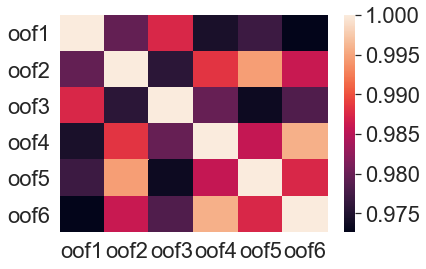

In [37]:
import seaborn as sns
corr = oof_all.corr()
sns.heatmap(corr,  xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [127]:
pred_all = np.column_stack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10])
oof_all  = np.column_stack([oof1, oof2, oof3, oof4, oof5, oof6, oof7, oof8, oof9, oof10])

pred_all = pd.DataFrame(data=pred_all, columns=['pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8',pred9,pred10])
oof_all = pd.DataFrame(data=oof_all, columns=['oof1','oof2','oof3','oof4','oof5','oof6','oof7','oof8','oof9','oof10'])

pred_all.shape, oof_all.shape

((146765, 10), (68284, 10))

In [131]:
pred_all = np.column_stack([pred2, pred4, pred5, pred6, pred7, pred8])
oof_all  = np.column_stack([oof2, oof4, oof5, oof6, oof7, oof8])

pred_all = pd.DataFrame(data=pred_all, columns=['pred2','pred4','pred5','pred6','pred7','pred8'])
oof_all = pd.DataFrame(data=oof_all, columns=['oof2','oof4','oof5','oof6','oof7','oof8'])

pred_all.shape, oof_all.shape

((146765, 6), (68284, 6))

In [130]:
for col in oof_all.columns:
    print(col,"=====", 100*np.sqrt(mean_squared_error(oof_all[col],y_val)))

print("All =====", 100*np.sqrt(mean_squared_error(oof_all.mean(axis=1),y_val)))

oof2 ===== 97.10662899258122
oof4 ===== 97.12380586792673
oof5 ===== 97.10239493830304
oof6 ===== 97.15305841644752
oof7 ===== 97.15513232612538
oof8 ===== 97.1443576625576
All ===== 97.03120298030944


In [132]:
sub_df_combine = sub_df.copy()
sub_df_combine.amount_spent_per_room_night_scaled = pred_all.mean(axis=1)
sub_df_combine.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.406757
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.442800
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.584993
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.881779
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.701911


In [133]:
sub_df_combine.to_csv('submissions/blending3.csv',index=None)

In [43]:
pred11.shape, pred1.shape

((68284,), (146765,))

In [45]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

params = {'alpha1': 2.2355246116841445, 'alpha2': 3.475120859161531, 'lambda1': 2.8006046056645264, 'lambda2': 0.6019080103763894}
bay_ridge = BayesianRidge(
    n_iter=300, tol=0.001, compute_score=False,
    alpha_1=params['alpha1'], alpha_2=params['alpha2'], 
    lambda_1=params['lambda1'], lambda_2=params['lambda2'],  
    fit_intercept=True, normalize=True, verbose=False)
bay_ridge.fit(train_2, y_tr)
oof11 = bay_ridge.predict(valid_2)
score = np.sqrt(mean_squared_error(y_val, oof11))
print("bay_ridge: ", score)

params = {'alpha': 419.51325861935135}
lasso = Lasso(
    alpha=params['alpha'], fit_intercept=True, normalize=True, 
    positive=False, random_state=1234, selection='cyclic')
lasso.fit(train_2, y_tr)
oof12 = lasso.predict(valid_2)
score = np.sqrt(mean_squared_error(y_val, oof12))
print("lasso: ", score)

params = {'alpha': 533.4683687235575}
elastic = ElasticNet(
    alpha=params['alpha'], l1_ratio=0.5, fit_intercept=True, 
    normalize=True, random_state=1234, selection='cyclic')
elastic.fit(train_2, y_tr)
oof13 = elastic.predict(valid_2)
score = np.sqrt(mean_squared_error(y_val, oof13))
print("elastic: ", score)


params = {'alpha': 6.942366317134041}
ridge = Ridge(
    alpha=params['alpha'], fit_intercept=True, normalize=True, 
    max_iter=500, random_state=1234)
ridge.fit(train_2, y_tr)
oof14 = ridge.predict(valid_2)
score = np.sqrt(mean_squared_error(y_val, oof14))
print("ridge: ", score)


bay_ridge:  1.000628435320114
lasso:  1.0927396582797244
elastic:  1.0927396582797244
ridge:  1.0692216961652803


In [46]:
# pred_all = np.column_stack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred11, pred12, pred13, pred4])
oof_all  = np.column_stack([oof1, oof2, oof3, oof4, oof5, oof6, oof7, oof8, oof11, oof12, oof13, oof14])

# pred_all = pd.DataFrame(data=pred_all, 
#             columns=['pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8', 'pred11','pred12','pred13','pred14'])
oof_all = pd.DataFrame(data=oof_all, 
                       columns=['oof1','oof2','oof3','oof4','oof5','oof6','oof7','oof8', 'oof11','oof12','oof13','oof14'])
print(pred_all.shape, oof_all.shape)

for col in oof_all.columns:
    print(col,"=====", 100*np.sqrt(mean_squared_error(oof_all[col],y_val)))

print("All =====", 100*np.sqrt(mean_squared_error(oof_all.mean(axis=1),y_val)))

(146765, 8) (68284, 12)
oof1 ===== 97.36469825204482
oof2 ===== 97.10662899258122
oof3 ===== 97.42595675910624
oof4 ===== 97.12380586792673
oof5 ===== 97.10239493830304
oof6 ===== 97.15305841644752
oof7 ===== 97.15513232612538
oof8 ===== 97.1443576625576
oof11 ===== 100.0628435320114
oof12 ===== 109.27396582797245
oof13 ===== 109.27396582797245
oof14 ===== 106.92216961652802
All ===== 98.14878920385915


In [55]:
params = {'x1':1, 'x2':1, 'x3':1, 'x4':1, 'x5':1}


array([1, 1, 1, 1, 1])

In [93]:

def bayesian_blending(x1,x2,x3,x4,x5,x6,x7,x8):
    blend_arr = np.array([x1,x2,x3,x4,x5,x6,x7,x8,0,0,0,0])
    oof = np.dot(oof_all.values, blend_arr)
    score = 100*np.sqrt(mean_squared_error(y_val, oof))
    
    return -score

params = {
    'x1'    : (0.1,0.7),
    'x2'    : (0.1,0.7),
    'x3'    : (0.1,0.7),
    'x4'    : (0.1,0.7),
    'x5'    : (0.1,0.7),
    'x6'    : (0.1,0.7),
    'x7'    : (0.1,0.7),
    'x8'    : (0.1,0.7),
#     'x9'    : (0,1),
#     'x10'   : (0,1),
#     'x11'   : (0,1),
#     'x12'   : (0,1),
    }
_bo = BayesianOptimization(bayesian_blending, params, random_state=26656)
_bo.maximize(init_points=100, n_iter=50, acq='ei')



|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.324e+0 |  0.2044   |  0.2223   |  0.3101   |  0.3507   |  0.6376   |  0.3622   |  0.3585   |  0.2599   |
|  2        | -1.837e+0 |  0.6777   |  0.1359   |  0.4587   |  0.2623   |  0.4638   |  0.3179   |  0.3802   |  0.6727   |
|  3        | -1.727e+0 |  0.1333   |  0.3577   |  0.4178   |  0.6662   |  0.4035   |  0.4676   |  0.537    |  0.2439   |
|  4        | -1.281e+0 |  0.5296   |  0.496    |  0.1349   |  0.2244   |  0.3296   |  0.3135   |  0.2457   |  0.3764   |
|  5        | -1.166e+0 |  0.249    |  0.4909   |  0.3041   |  0.2348   |  0.2216   |  0.2955   |  0.4383   |  0.2663   |
|  6        | -1.742e+0 |  0.2415   |  0.618    |  0.3891   |  0.3155   |  0.6998   |  0.3078   |  0.4639   |  0.2117   |
|  7        | -972.0    

|  86       | -2.004e+0 |  0.3708   |  0.6604   |  0.6602   |  0.5037   |  0.2324   |  0.3285   |  0.5212   |  0.3083   |
|  87       | -1.84e+03 |  0.6838   |  0.3429   |  0.2818   |  0.1894   |  0.6167   |  0.2874   |  0.676    |  0.2956   |
|  88       | -1.364e+0 |  0.2557   |  0.2225   |  0.5144   |  0.4992   |  0.2432   |  0.1022   |  0.4262   |  0.4941   |
|  89       | -1.823e+0 |  0.5984   |  0.3378   |  0.2668   |  0.6719   |  0.134    |  0.371    |  0.6469   |  0.3247   |
|  90       | -2.259e+0 |  0.5364   |  0.6628   |  0.5465   |  0.4842   |  0.4734   |  0.3062   |  0.5941   |  0.3121   |
|  91       | -1.93e+03 |  0.4636   |  0.3931   |  0.6692   |  0.5365   |  0.1882   |  0.3298   |  0.2694   |  0.6397   |
|  92       | -1.95e+03 |  0.6293   |  0.6784   |  0.3336   |  0.1651   |  0.3029   |  0.4099   |  0.5627   |  0.434    |
|  93       | -2.305e+0 |  0.4295   |  0.5708   |  0.5426   |  0.2133   |  0.6315   |  0.5085   |  0.4157   |  0.6636   |
|  94       | -1.448e+0 

|  127      | -1.388e+0 |  0.2155   |  0.1691   |  0.179    |  0.3788   |  0.4811   |  0.5762   |  0.3425   |  0.4466   |
|  128      | -1.13e+03 |  0.1555   |  0.3887   |  0.2527   |  0.2961   |  0.4021   |  0.2797   |  0.2452   |  0.4337   |
|  129      | -1.671e+0 |  0.4889   |  0.4367   |  0.2487   |  0.5896   |  0.2158   |  0.1918   |  0.3351   |  0.6487   |
|  130      | -1.412e+0 |  0.491    |  0.4822   |  0.3813   |  0.4363   |  0.4676   |  0.1633   |  0.1773   |  0.2201   |
|  131      | -2.292e+0 |  0.2992   |  0.6789   |  0.2971   |  0.6716   |  0.3297   |  0.529    |  0.6275   |  0.5252   |
|  132      | -1.684e+0 |  0.4554   |  0.5599   |  0.5836   |  0.2707   |  0.4282   |  0.1543   |  0.2739   |  0.4459   |
|  133      | -2.099e+0 |  0.4592   |  0.6765   |  0.5541   |  0.3019   |  0.5583   |  0.3822   |  0.5156   |  0.2605   |
|  134      | -1.621e+0 |  0.5802   |  0.3625   |  0.4345   |  0.3357   |  0.435    |  0.2462   |  0.2035   |  0.4931   |
|  135      | -1.782e+0 

In [94]:
_bo.max

{'target': -381.6384066433076,
 'params': {'x1': 0.2674315566452321,
  'x2': 0.16013716620627516,
  'x3': 0.11679020400100137,
  'x4': 0.11243671386023227,
  'x5': 0.38449807435146854,
  'x6': 0.12274504518701046,
  'x7': 0.1309608872622326,
  'x8': 0.18134371934085636}}

In [75]:
_bo.max

{'target': -0.9748488683406558,
 'params': {'x1': 0.2038227553186598,
  'x2': 0.14745655012879733,
  'x3': 0.02640723963543179,
  'x4': 0.1549382177472065,
  'x5': 0.0889732308619049,
  'x6': 0.05551558943556523,
  'x7': 0.19703326683642564,
  'x8': 0.13721155280467745}}

In [88]:
gc.collect()

0

In [89]:
del train_3, train_4, test_df3, test_df4, valid_3, valid_4
gc.collect()

997

In [23]:
mean_squared_error(oof_all.iloc[train_index3].mean(axis=1), y_tr3), mean_squared_error(oof_all.iloc[test_index3].mean(axis=1), y_val3)

(1.3718627693765908, 1.3805485963557262)

In [76]:
params =  {
  'x1': 0.2038227553186598,
  'x2': 0.14745655012879733,
  'x3': 0.02640723963543179,
  'x4': 0.1549382177472065,
  'x5': 0.0889732308619049,
  'x6': 0.05551558943556523,
  'x7': 0.19703326683642564,
  'x8': 0.13721155280467745}
np.array(list(params.values()))

array([0.20382276, 0.14745655, 0.02640724, 0.15493822, 0.08897323,
       0.05551559, 0.19703327, 0.13721155])

In [77]:
pred_all = np.column_stack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8])
pred_all = pd.DataFrame(data=pred_all, columns=['pred1','pred2','pred3','pred4','pred5','pred6','pred7','pred8'])

blend_arr = np.array(list(params.values()))
oof = np.dot(oof_all.iloc[:,:8].values, blend_arr)
score = mean_squared_error(y_val, oof)
print("weighted blending: ", score)

result = np.dot(pred_all.values, blend_arr)
sub_df_combine = sub_df.copy()
sub_df_combine.amount_spent_per_room_night_scaled = result
sub_df_combine.head()

weighted blending:  0.9503303161050572


,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.513799
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.562273
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.683749
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.981164
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.816991


In [78]:
sub_df_combine.to_csv('wts_blending.csv', index=None)

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
    print(X_train.shape, X_valid.shape)
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)

        return -score


    _bo = BayesianOptimization(train_lgb_model, {

        'b_frac'       : (0.2,0.7),
        'f_frac'       : (0.2,0.8),
        'leaves'       : (10,120), # int
        'split_gain'   : (0, 1),
        'l1'           : (0, 4),
        'l2'           : (0, 4),
        'data_in_leaf' : (200, 1000), # int
        'hessian'      : (0, 20),


    }, random_state=23456)
    _bo.maximize(init_points=40, n_iter=15, acq='ei')
    
    return _bo


In [28]:
bo_tuning_lgb2 = bayesian_opt_lgb(oof_all.iloc[train_index3], y_tr3, oof_all.iloc[test_index3], y_val3, list(oof_all.columns))


(113808, 6) (56904, 6)
|   iter    |  target   |  b_frac   | data_i... |  f_frac   |  hessian  |    l1     |    l2     |  leaves   | split_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.15     |  0.3609   |  461.8    |  0.7565   |  6.234    |  0.6478   |  1.456    |  68.21    |  0.7891   |
|  2        | -1.15     |  0.6377   |  709.3    |  0.7938   |  16.32    |  0.1652   |  0.8117   |  26.76    |  0.7531   |
|  3        | -1.15     |  0.4276   |  963.7    |  0.7624   |  2.708    |  0.9436   |  1.259    |  84.0     |  0.6206   |
|  4        | -1.15     |  0.5111   |  870.3    |  0.5785   |  11.22    |  3.947    |  2.733    |  21.15    |  0.9401   |
|  5        | -1.15     |  0.5257   |  381.9    |  0.4591   |  7.802    |  3.023    |  0.5706   |  11.08    |  0.8379   |
|  6        | -1.15     |  0.2544   |  399.4    |  0.4855   |  17.68    |  0.7099   |  3.144    |  13.86    |  0.6086   |
|

|  41       | -1.15     |  0.27     |  204.8    |  0.4487   |  0.261    |  1.616    |  1.574    |  10.85    |  0.06603  |
|  42       | -1.15     |  0.2463   |  207.6    |  0.7219   |  19.63    |  3.044    |  0.4971   |  119.3    |  0.02356  |
|  43       | -1.15     |  0.4604   |  994.7    |  0.3862   |  19.71    |  3.562    |  0.2088   |  119.6    |  0.4269   |


KeyboardInterrupt: 

In [14]:
# cols_to_drop= ['res_staResidence_median','tr_flag','reservationstatusid_code',
#                'res_resortType_median','res_stResort_median','res_cluster_median',
#                'booking_date','checkin_date','checkout_date']
# train_test.drop(cols_to_drop, axis=1, inplace=True)

# for col in train_test.columns:
#     if col != 'amount_spent_per_room_night_scaled':
#         train_test[col] = train_test[col].astype('category').cat.codes

In [97]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
    print(X_train.shape, X_valid.shape)
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)

        return -score


    _bo = BayesianOptimization(train_lgb_model, {

        'b_frac'       : (0.2,0.7),
        'f_frac'       : (0.2,0.8),
        'leaves'       : (30,120), # int
        'split_gain'   : (0, 1),
        'l1'           : (0, 4),
        'l2'           : (0, 4),
        'data_in_leaf' : (200, 1000), # int
        'hessian'      : (0, 50),


    }, random_state=23456)
    _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return _bo


In [98]:
bo_tuning_lgb = bayesian_opt_lgb(train_, y_tr, valid_, y_val, list(train_.columns))


(256068, 50) (85356, 50)
|   iter    |  target   |  b_frac   | data_i... |  f_frac   |  hessian  |    l1     |    l2     |  leaves   | split_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.9418   |  0.3609   |  461.8    |  0.7565   |  15.58    |  0.6478   |  1.456    |  77.63    |  0.7891   |
|  2        | -0.9417   |  0.6377   |  709.3    |  0.7938   |  40.79    |  0.1652   |  0.8117   |  43.72    |  0.7531   |
|  3        | -0.9419   |  0.4276   |  963.7    |  0.7624   |  6.77     |  0.9436   |  1.259    |  90.54    |  0.6206   |
|  4        | -0.9416   |  0.5111   |  870.3    |  0.5785   |  28.05    |  3.947    |  2.733    |  39.12    |  0.9401   |
|  5        | -0.941    |  0.5257   |  381.9    |  0.4591   |  19.5     |  3.023    |  0.5706   |  30.89    |  0.8379   |
|  6        | -0.9413   |  0.2544   |  399.4    |  0.4855   |  44.2     |  0.7099   |  3.144    |  33.15    |  0.6086   |

In [99]:
bo_tuning_lgb.max

{'target': -0.9407226576692649,
 'params': {'b_frac': 0.2728072019276865,
  'data_in_leaf': 599.1355067878178,
  'f_frac': 0.4937418834592164,
  'hessian': 6.198622176728424,
  'l1': 1.826600484273437,
  'l2': 0.1849162529109467,
  'leaves': 88.2210088397349,
  'split_gain': 0.3879558806359651}}

In [112]:
lgb = bayesian_opt_lgb(train_, y_tr, valid_, y_val, list(train_.columns))


Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.991204	valid_1's rmse: 0.992949
[400]	training's rmse: 0.972037	valid_1's rmse: 0.978365
[600]	training's rmse: 0.962675	valid_1's rmse: 0.973745
[800]	training's rmse: 0.956065	valid_1's rmse: 0.971817
[1000]	training's rmse: 0.950618	valid_1's rmse: 0.970888
[1200]	training's rmse: 0.945932	valid_1's rmse: 0.970429
[1400]	training's rmse: 0.941607	valid_1's rmse: 0.970132
[1600]	training's rmse: 0.937541	valid_1's rmse: 0.969986
Early stopping, best iteration is:
[1773]	training's rmse: 0.934178	valid_1's rmse: 0.969909
=== rmse:  96.99085821196061


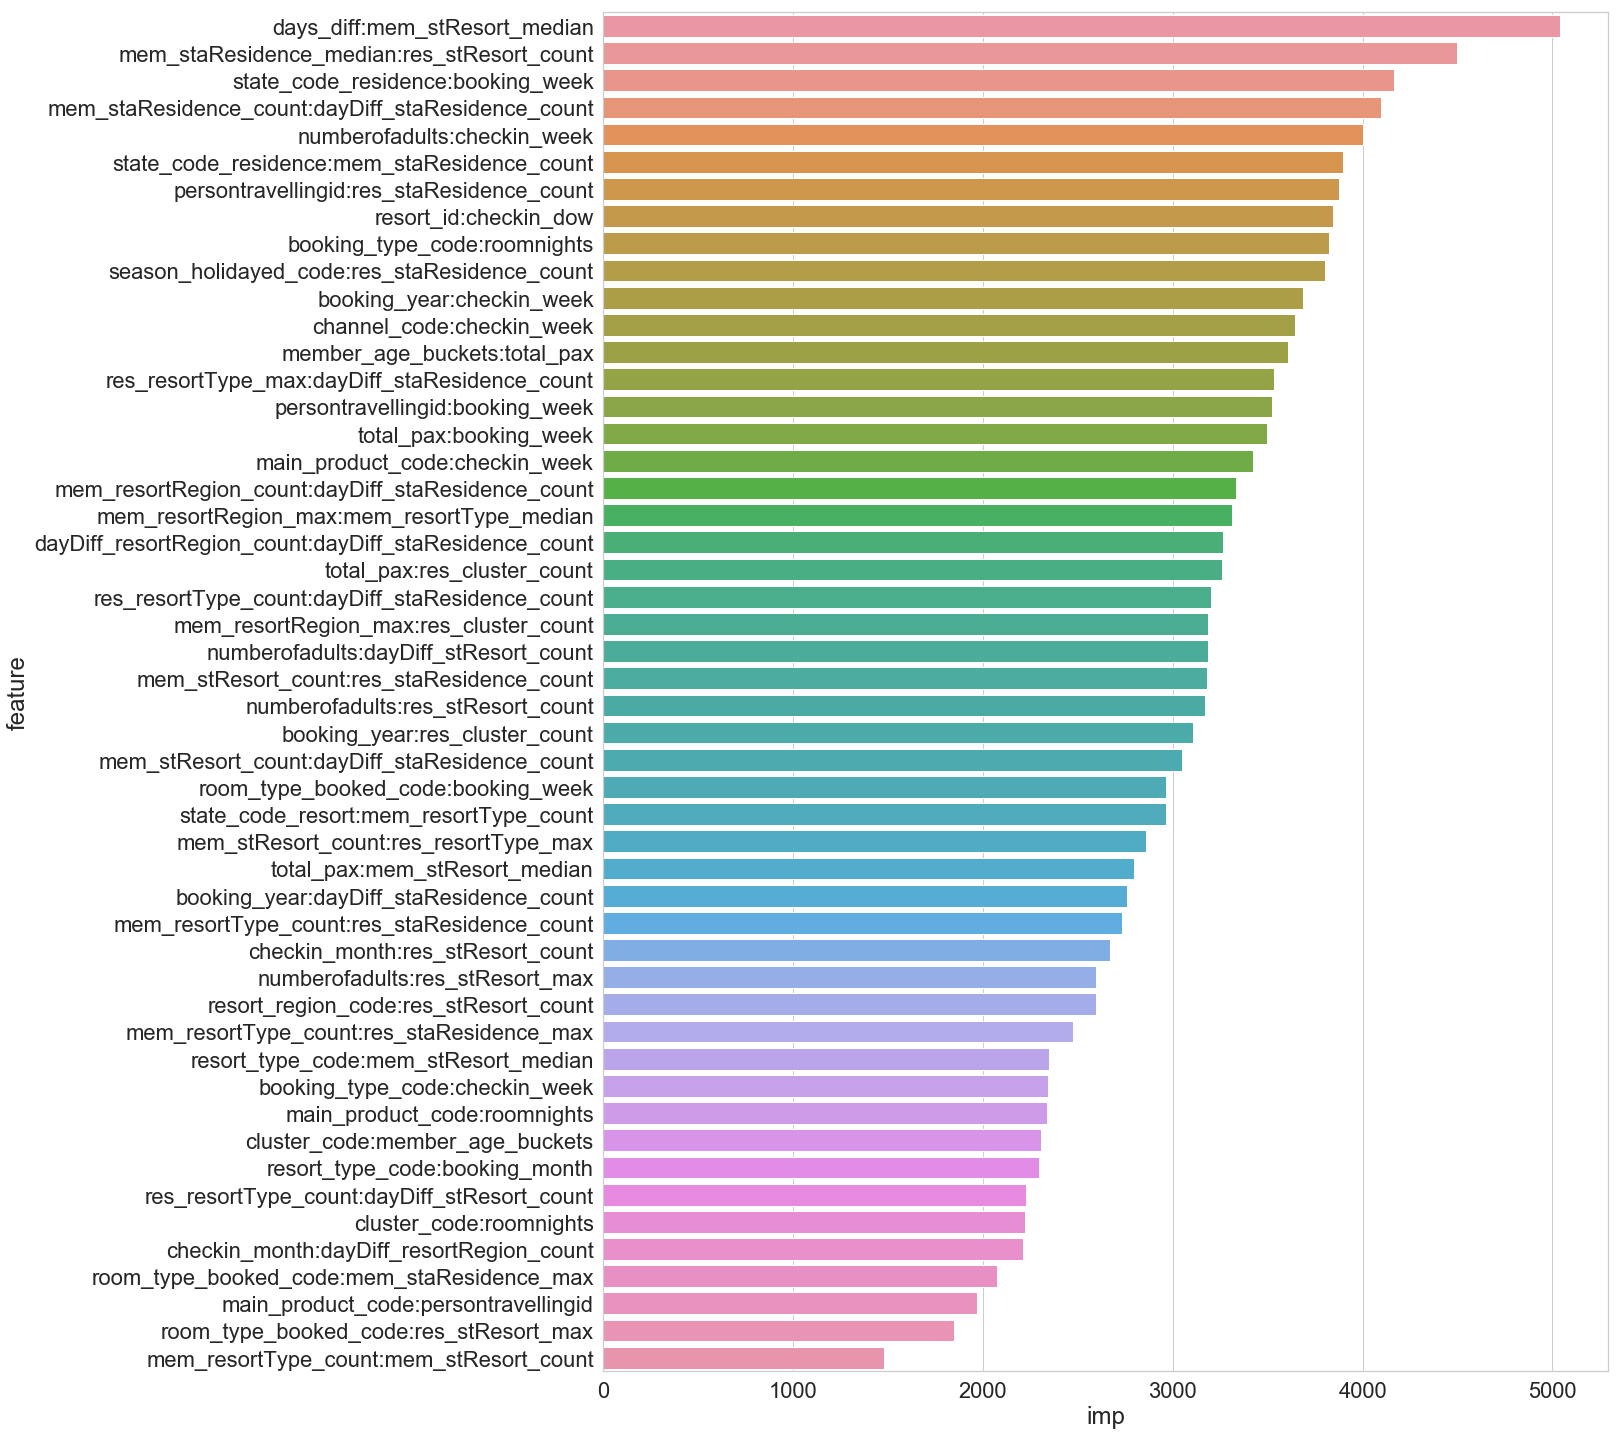

In [113]:
lgb_imp = pd.DataFrame(data=[lgb.feature_name(), list(lgb.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
fig, ax = plt.subplots(1,1,figsize=(18, 25))
sns.barplot(x='imp',y='feature',data=lgb_imp, ax=ax)



In [107]:
feat_inter = list(train_.columns)
feat_inter_pairs = [row.split(':') for row in feat_inter]

feat_inter_df = pd.DataFrame(data=feat_inter_pairs, columns=['col1','col2'])
feat_inter_df.to_csv('data/feature_inter_list.csv',index=None)

In [111]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 3,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 1,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=200, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)
        print("=== rmse: ", np.sqrt(score)*100)
        print("="*50)
#         pred = clf.predict(test[features], num_iteration=clf.best_iteration)
        
        return clf#, pred
# {'target': -0.9407226576692649,
#  'params': {'b_frac': 0.2728072019276865,
#   'data_in_leaf': 599.1355067878178,
#   'f_frac': 0.4937418834592164,
#   'hessian': 6.198622176728424,
#   'l1': 1.826600484273437,
#   'l2': 0.1849162529109467,
#   'leaves': 88.2210088397349,
#   'split_gain': 0.3879558806359651}}

    clf = train_lgb_model(**{ 'b_frac': 0.2728072019276865,
                              'data_in_leaf': 599.1355067878178,
                              'f_frac': 0.4937418834592164,
                              'hessian': 6.198622176728424,
                              'l1': 1.826600484273437,
                              'l2': 0.1849162529109467,
                              'leaves': 88.2210088397349,
                              'split_gain': 0.3879558806359651
                            })
#     _bo = BayesianOptimization(train_lgb_model, {
#         'b_frac'       : (0.2,0.7),
#         'f_frac'       : (0.2,0.8),
#         'leaves'             : (20,90), # int
#         'split_gain'      : (0, 10),
#         'l1'              : (0, 5),
#         'l2'              : (0, 5),
#         'data_in_leaf'       : (20, 500), # int
#         'hessian': (0, 100),
#         }, random_state=23456)
    
#     _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return clf

In [95]:
# feature_collect_df.shape

# train_, valid_, y_tr, y_val = get_data(feature_collect_df[list(feature_collect_columns[idx])], target, memberids)


# def get_data(df, target, groupid):

# group_kfold = GroupKFold(n_splits=4)
# for train_index, test_index in group_kfold.split(feature_collect_df[list(feature_collect_columns[idx])].iloc[:train_len], target, memberids):
#     print(train_index.shape, test_index.shape)
# #     train_, valid_ = df.iloc[train_index], df.iloc[test_index]
#     y_tr, y_val    = target[train_index], target[test_index]
#     break
        
#     return train_, valid_, y_tr, y_val



In [19]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 3,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)
        print("=== rmse: ", np.sqrt(score)*100)
        print("="*50)
#         pred = clf.predict(test[features], num_iteration=clf.best_iteration)
        
        return clf#, pred


    clf = train_lgb_model(**{
        'b_frac': 0.3677516358370858,
        'data_in_leaf': 495.44417416221626,
        'f_frac': 0.5422060360159515,
        'hessian': 5.039378213231793,
        'l1': 1.0642598045225304,
        'l2': 2.564544963055539,
        'leaves': 89.62655396835916,
        'split_gain': 0.16542750189034394
    })
#     _bo = BayesianOptimization(train_lgb_model, {
#         'b_frac'       : (0.2,0.7),
#         'f_frac'       : (0.2,0.8),
#         'leaves'             : (20,90), # int
#         'split_gain'      : (0, 10),
#         'l1'              : (0, 5),
#         'l2'              : (0, 5),
#         'data_in_leaf'       : (20, 500), # int
#         'hessian': (0, 100),
#         }, random_state=23456)
    
#     _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return clf

In [47]:
lgb1 = bayesian_opt_lgb(feature_df.iloc[:341424-10000], target[:341424-10000], 
                        feature_df.iloc[341424-10000:341424], target[341424-10000:341424], feature_df.columns)

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.990806	valid_1's rmse: 1.0655
[400]	training's rmse: 0.97286	valid_1's rmse: 1.05266
[600]	training's rmse: 0.964631	valid_1's rmse: 1.04874
[800]	training's rmse: 0.959197	valid_1's rmse: 1.04741
[1000]	training's rmse: 0.954916	valid_1's rmse: 1.04655
[1200]	training's rmse: 0.951325	valid_1's rmse: 1.04586
[1400]	training's rmse: 0.948293	valid_1's rmse: 1.04538
[1600]	training's rmse: 0.94556	valid_1's rmse: 1.04503
[1800]	training's rmse: 0.943014	valid_1's rmse: 1.04473
[2000]	training's rmse: 0.940522	valid_1's rmse: 1.04447
Early stopping, best iteration is:
[1978]	training's rmse: 0.940799	valid_1's rmse: 1.04446
rmse:  104.44583593668193


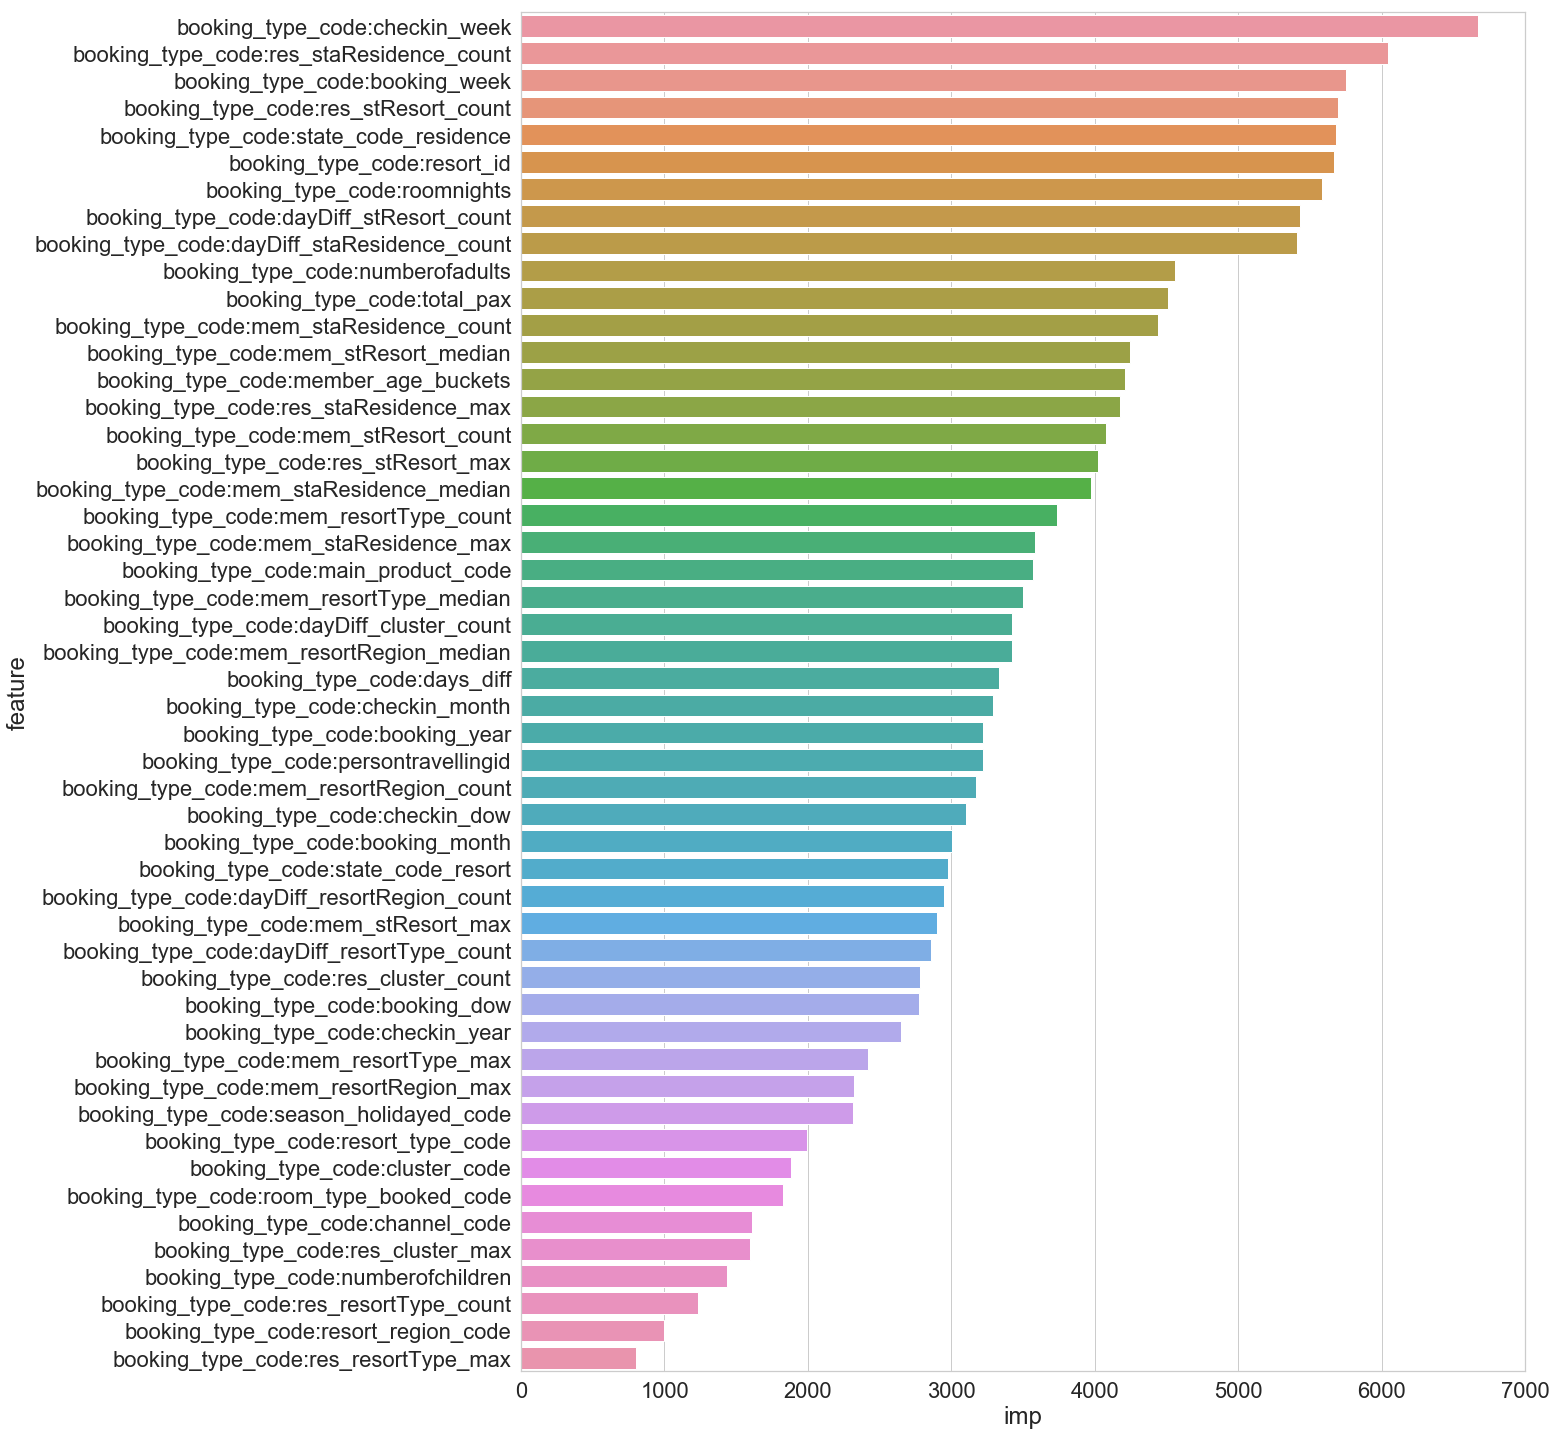

In [48]:
lgb_imp = pd.DataFrame(data=[lgb1.feature_name(), list(lgb1.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
fig, ax = plt.subplots(1,1,figsize=(18, 25))
sns.barplot(x='imp',y='feature',data=lgb_imp, ax=ax)


In [52]:
lgb_imp

,feature,imp
21,booking_type_code:checkin_week,6670
37,booking_type_code:res_staResidence_count,6043
17,booking_type_code:booking_week,5750
39,booking_type_code:res_stResort_count,5699
13,booking_type_code:state_code_residence,5681
7,booking_type_code:resort_id,5669
11,booking_type_code:roomnights,5585
48,booking_type_code:dayDiff_stResort_count,5431
47,booking_type_code:dayDiff_staResidence_count,5407
4,booking_type_code:numberofadults,4561


In [58]:
target = target[:341424]
memberids = memberids[:341424]

In [9]:
train_len = 341424

train_df = train_test.iloc[:train_len]
test_df  = train_test.iloc[train_len:]
test_df = test_df.reset_index(drop=True)

target = train_df['amount_spent_per_room_night_scaled']

train_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)
test_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)

print(train_df.shape, test_df.shape, target.shape)

print("Shape: ", train_df.shape, " ==> ", end=" ")

train_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)
test_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)

print(train_df.shape)


(341424, 61) (146765, 61) (341424,)
Shape:  (341424, 61)  ==>  (341424, 58)


In [10]:
len(set(train_df.memberid)), len(set(test_df.memberid)), len(set(train_df.memberid).intersection(set(test_df.memberid)))

(101327, 43496, 0)

In [5]:
# for col in train_df.columns:
#     train_df[col] = train_df[col].astype('category').cat.codes

In [11]:
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

group_kfold = GroupKFold(n_splits=4)

print(group_kfold)

for train_index, test_index in group_kfold.split(train_df.drop('memberid', axis=1), target, train_df['memberid']):
#     print("TRAIN:", train_index, "TEST:", test_index)
    train_, valid_ = train_df.iloc[train_index], train_df.iloc[test_index]
    y_tr, y_val    = target[train_index], target[test_index]
    break

train_.shape, valid_.shape, y_tr.shape, y_val.shape, test_df.shape

GroupKFold(n_splits=4)


((256068, 58), (85356, 58), (256068,), (85356,), (146765, 58))

In [12]:
train_.drop('memberid', axis=1, inplace=True)
valid_.drop('memberid', axis=1, inplace=True)
test_df.drop('memberid', axis=1, inplace=True)

In [13]:
del train_df, train_test
gc.collect()

21

In [22]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, test, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 1,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=200, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)
        print("rmse: ", np.sqrt(score)*100)
        
        pred = clf.predict(test[features], num_iteration=clf.best_iteration)
        
        return clf, pred


    clf, pred = train_lgb_model(**{
        'b_frac': 0.3677516358370858,
        'data_in_leaf': 495.44417416221626,
        'f_frac': 0.5422060360159515,
        'hessian': 5.039378213231793,
        'l1': 1.0642598045225304,
        'l2': 2.564544963055539,
        'leaves': 89.62655396835916,
        'split_gain': 0.16542750189034394
    })
#     _bo = BayesianOptimization(train_lgb_model, {
#         'b_frac'       : (0.2,0.7),
#         'f_frac'       : (0.2,0.8),
#         'leaves'             : (20,90), # int
#         'split_gain'      : (0, 10),
#         'l1'              : (0, 5),
#         'l2'              : (0, 5),
#         'data_in_leaf'       : (20, 500), # int
#         'hessian': (0, 100),
#         }, random_state=23456)
    
#     _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return clf, pred

In [23]:
clf, pred = bayesian_opt_lgb(train_, y_tr, valid_, y_val, test_df, train_.columns)

Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 0.989467	valid_1's rmse: 0.990075
[400]	training's rmse: 0.971121	valid_1's rmse: 0.975702
[600]	training's rmse: 0.962781	valid_1's rmse: 0.971302
[800]	training's rmse: 0.95706	valid_1's rmse: 0.969436
[1000]	training's rmse: 0.952331	valid_1's rmse: 0.968531
[1200]	training's rmse: 0.948364	valid_1's rmse: 0.968033
[1400]	training's rmse: 0.944765	valid_1's rmse: 0.967804
[1600]	training's rmse: 0.94142	valid_1's rmse: 0.967662
Early stopping, best iteration is:
[1717]	training's rmse: 0.939571	valid_1's rmse: 0.967588
rmse:  96.75880871582146


In [30]:
lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)


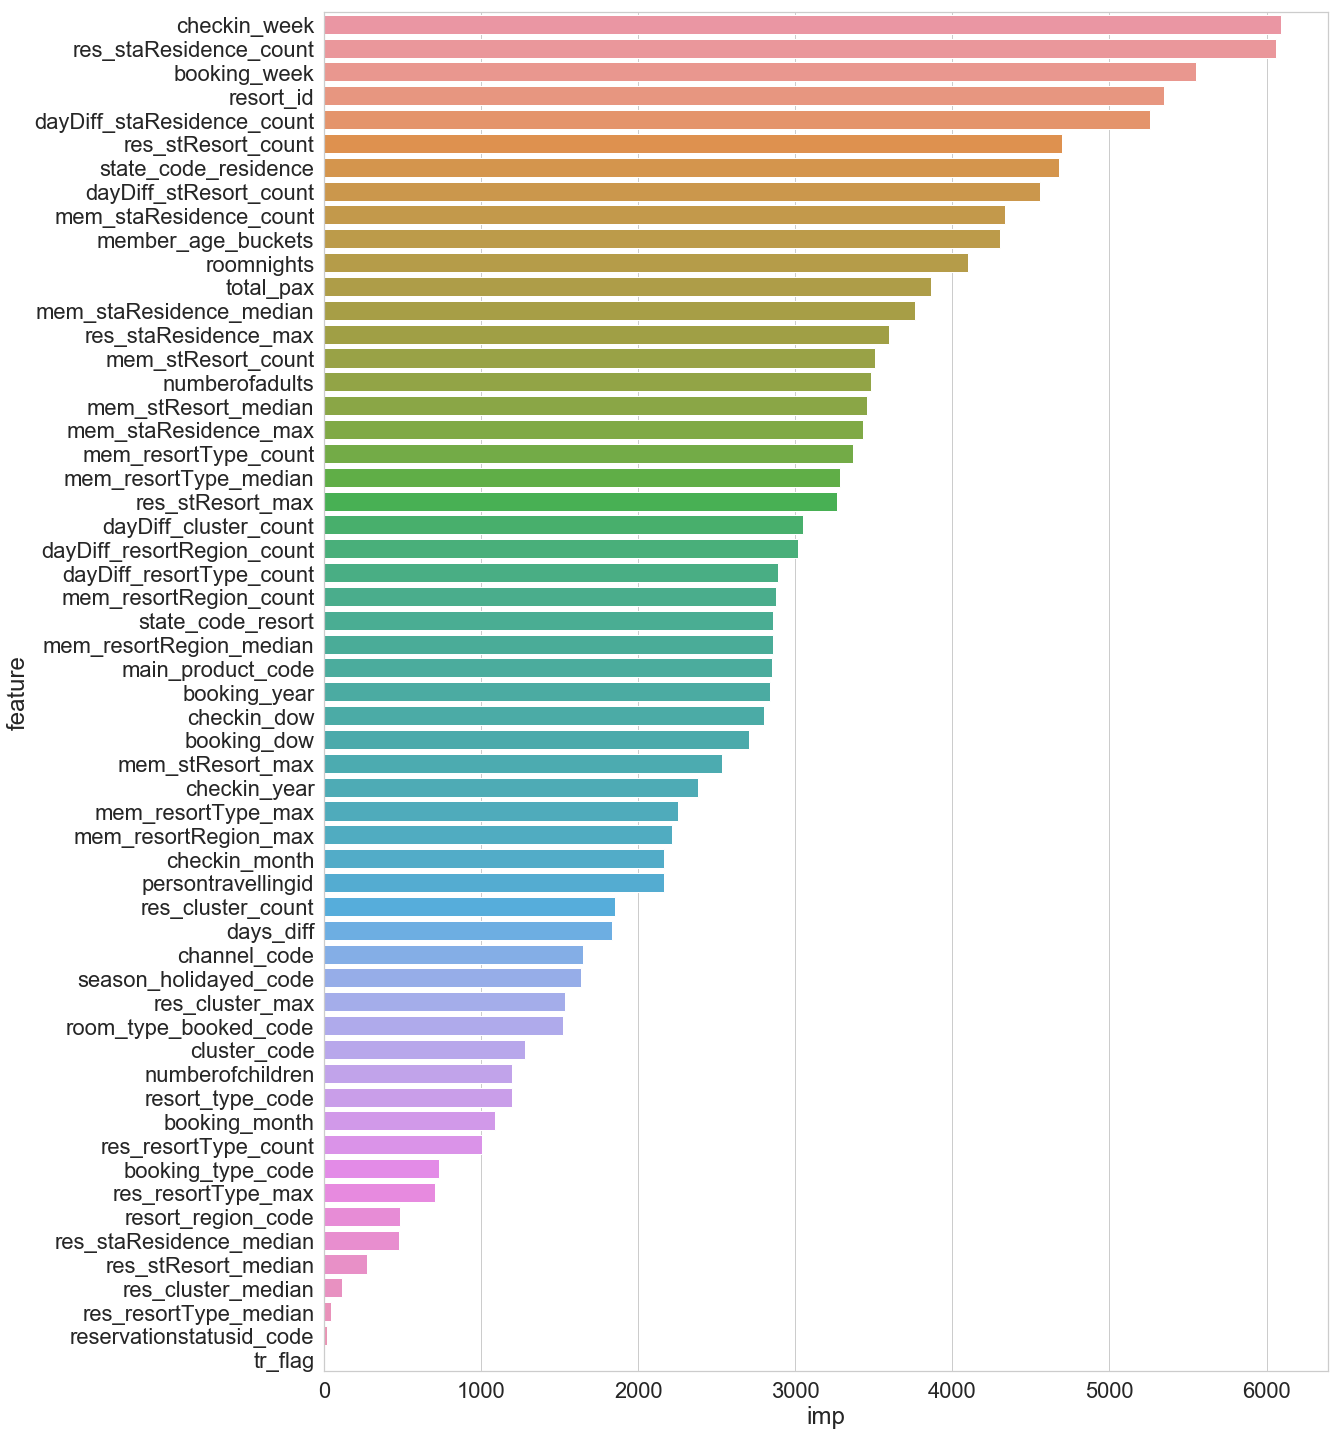

In [31]:

fig, ax = plt.subplots(1,1,figsize=(18, 25))
sns.barplot(x='imp',y='feature',data=lgb_imp, ax=ax)



In [34]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_cat(X_train, y_train, X_valid, y_valid, test, features):
        
    def train_cat_model(r_str, b_temp, l2, depth):
    
        params = {}
        params['random_strength']     = max(min(r_str, 1), 0)
        params['bagging_temperature'] = max(b_temp, 0)
        params['l2_leaf_reg'] = max(l2, 0)
        params['depth']     = int(depth)

        param_const = {
            'border_count'          : 63,
            'early_stopping_rounds' : 50,
            'random_seed'           : 1337,
            'task_type'             : 'CPU', 
            'loss_function'         : "RMSE", 
    #         'subsample'             = 0.7, 
            'iterations'            : 10000, 
            'learning_rate'         : 0.01,
            'thread_count'          : 4,
#             'bootstrap_type'        : 'No'
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

        watchlist = [_train, _valid]
        clf = CatBoostRegressor(**params)
        clf.fit(_train, 
                eval_set=watchlist, 
                verbose=200,
                use_best_model=True)

        oof  = clf.predict(X_valid[features])
        score = mean_squared_error(y_valid, oof)
        print("rmse: ", np.sqrt(score)*100)
        
        pred = clf.predict(test[features])
        
        return clf, pred

    clf, pred = train_cat_model(**{'b_temp': 0.08307474720468191,
                                  'depth': 7.596402546589758,
                                  'l2': 3.9791105400066655,
                                  'r_str': 1.1206250787323229})

    
#     _bo = BayesianOptimization(train_cat_model, {

#         'r_str'      : (1, 5),
#         'b_temp'     : (0.01, 100),
#         'depth'      : (3,8), # int
# #         'subsample'  : (0.3, 0.8),
# #         'data_leaf'  : (2,7),
#         'l2'         : (0, 5),

#     }, random_state=23456)
#     _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return clf, pred



In [35]:
clf_cat, pred_cat = bayesian_opt_cat(train_, y_tr, valid_, y_val, test_df, train_.columns)

0:	learn: 7.7214949	test: 7.7214949	test1: 7.7192231	best: 7.7192231 (0)	total: 71.5ms	remaining: 11m 54s
200:	learn: 1.4570252	test: 1.4570252	test1: 1.4533624	best: 1.4533624 (200)	total: 11s	remaining: 8m 54s
400:	learn: 1.0058490	test: 1.0058490	test1: 1.0033813	best: 1.0033813 (400)	total: 22.7s	remaining: 9m 2s
600:	learn: 0.9842248	test: 0.9842248	test1: 0.9826995	best: 0.9826995 (600)	total: 34s	remaining: 8m 50s
800:	learn: 0.9787329	test: 0.9787329	test1: 0.9779185	best: 0.9779185 (800)	total: 43.9s	remaining: 8m 24s
1000:	learn: 0.9755630	test: 0.9755630	test1: 0.9754979	best: 0.9754979 (1000)	total: 53.7s	remaining: 8m 2s
1200:	learn: 0.9732000	test: 0.9732000	test1: 0.9739315	best: 0.9739315 (1200)	total: 1m 3s	remaining: 7m 45s
1400:	learn: 0.9709259	test: 0.9709259	test1: 0.9724766	best: 0.9724766 (1400)	total: 1m 13s	remaining: 7m 28s
1600:	learn: 0.9688846	test: 0.9688846	test1: 0.9715245	best: 0.9715245 (1600)	total: 1m 22s	remaining: 7m 13s
1800:	learn: 0.9670901	tes

In [36]:
cat_imp = pd.DataFrame(data=[clf_cat.feature_names_, list(clf_cat.feature_importances_)]).T
cat_imp.columns = ['feature','imp']
cat_imp.imp = cat_imp.imp.astype('float')
cat_imp = cat_imp.sort_values(by='imp', ascending=False)

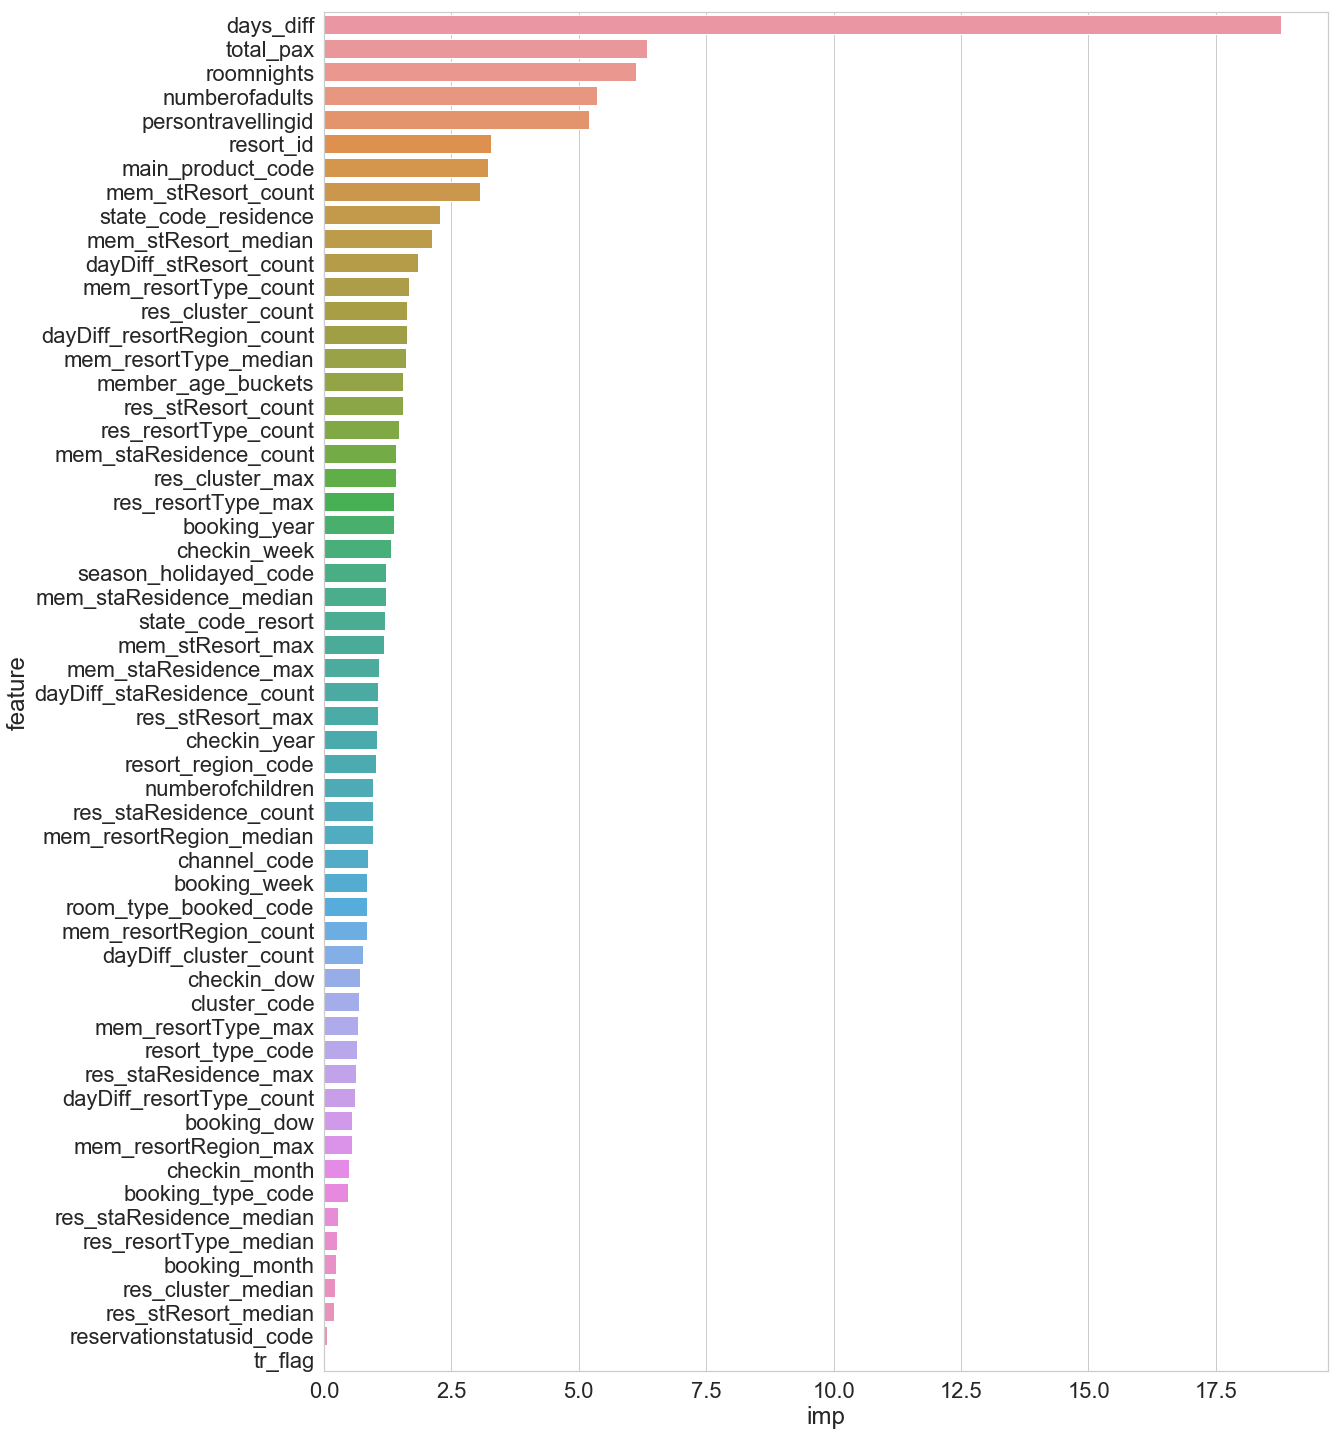

In [37]:
fig, ax = plt.subplots(1,1,figsize=(18, 25))
sns.barplot(x='imp',y='feature',data=cat_imp, ax=ax)


In [41]:
sub_df_lgb = sub_df.copy()
sub_df_lgb['amount_spent_per_room_night_scaled'] = pred

sub_df_cat = sub_df.copy()
sub_df_cat['amount_spent_per_room_night_scaled'] = pred_cat


In [42]:
# sub_df_cat.to_csv()
import os
os.makedirs('submissions')

In [43]:
sub_df_cat.to_csv('submissions/sub_cat.csv',index=None)
sub_df_lgb.to_csv('submissions/sub_lgb.csv',index=None)


# feature importance analysis

In [45]:
cat_imp.tail(10).append(lgb_imp.tail(10))

,feature,imp
30,mem_resortRegion_max,0.548422
25,checkin_month,0.483941
0,booking_type_code,0.47851
40,res_staResidence_median,0.280551
49,res_resortType_median,0.257104
21,booking_month,0.232768
46,res_cluster_median,0.217347
43,res_stResort_median,0.202727
8,reservationstatusid_code,0.0597548
18,tr_flag,0


In [48]:
cols_to_drop= ['res_staResidence_median','tr_flag','reservationstatusid_code',
               'res_resortType_median','res_stResort_median','res_cluster_median']
train_.drop(cols_to_drop, axis=1, inplace=True)
valid_.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop(cols_to_drop, axis=1, inplace=True)


In [49]:
train_.apply(lambda x: pd.Series.value_counts(x).shape[0])

booking_type_code               2
channel_code                    3
cluster_code                    6
main_product_code               5
member_age_buckets             10
numberofadults                  9
numberofchildren               11
persontravellingid              6
resort_id                      32
resort_region_code              3
resort_type_code                7
room_type_booked_code           6
roomnights                     43
season_holidayed_code           5
state_code_residence           38
state_code_resort              11
total_pax                       8
days_diff                       8
booking_week                   53
booking_month                  12
booking_year                    6
booking_dow                     7
checkin_week                   53
checkin_month                  12
checkin_year                    6
checkin_dow                     7
mem_resortRegion_median        59
mem_resortRegion_count         26
mem_resortRegion_max           41
mem_resortType

In [ ]:
print("len of interst cols: ", len(intersting_cols))

for i in range(len(intersting_cols)-1):
    feature_df = pd.DataFrame()
    col1 = intersting_cols[i]
    for j in range(i+1,len(intersting_cols)):
        col2 = intersting_cols[j]
        feature_df[col1+':'+col2] = complete_df[col1]+':'+complete_df[col2]
    
    feature_df.to_csv('store_data/new_feat/cat_inter_2way_'+str(i)+'.csv', index=None)
    print(feature_df.shape)
    
#         train_df[col1+':'+col2] = train_df[col1]+':'+train_df[col2]
#         test_df[col1+':'+col2]  = test_df[col1]+':'+test_df[col2]
        
print(train_df.shape)

In [173]:
train_1 = train_.copy()
valid_1 = valid_.copy()

train_1.shape, valid_1.shape

((256068, 57), (85356, 57))

In [175]:

import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def get_normalization(train_df, test_df, which_norm=None, int_cols=None, cat_cols=None):
    """ normalization of data features
    Args:
        train_df, test_df
        which_norm: normalization for numerical columns, ['stdc', 'min-max']
        int_cols: list of numerical_columns
        cat_cols: list of categorical columns
    Return:
        standarization scaled version for numeric data
        min-max scaled version for categorical data
    example:

        from sklearn import datasets
        iris = datasets.load_iris()
        X = iris.data; y = iris.target
        X = pd.DataFrame(data=X, columns=iris['feature_names'])
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], 'min-max',int_cols=X.columns)
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], int_cols='sepal width (cm)')
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], int_cols=X.columns)
    """
    complete_df = pd.concat([train_df, test_df], axis=0)

    stdc = StandardScaler()
    min_max = MinMaxScaler()

    if int_cols is not None:
        if which_norm == 'stdc': norm = StandardScaler()
        elif which_norm == 'min-max': norm = MinMaxScaler()
        else: 
            norm = StandardScaler()
            print("by default: stdc norm is running")
        try: 
            complete_df[int_cols] = norm.fit_transform(complete_df[int_cols])
        except: 
            # expecting a 2d array, but passed i-d array
            complete_df[[int_cols]] = norm.fit_transform(complete_df[[int_cols]])
        print("done with stdc normalization on numerical columns")
        
    if cat_cols is not None:
        norm = MinMaxScaler()
        try: 
            complete_df[cat_cols] = norm.fit_transform(complete_df[cat_cols])
        except:
            complete_df[[cat_cols]] = norm.fit_transform(complete_df[[cat_cols]])
        print("done with min-max normalization on categorical columns")

    train_df_new = complete_df.iloc[:train_df.shape[0],:]
    test_df_new  = complete_df.iloc[train_df.shape[0]:,:]
#     print(train_df_new.shape, test_df_new.shape)
    
    test_df_new = test_df_new.reset_index(drop=True)
    
    del complete_df
    gc.collect()
    return train_df_new, test_df_new
    


In [176]:
train_1, valid_1 = get_normalization(train_1, valid_1, cat_cols=list(train_1.columns))

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done with min-max normalization on categorical columns


In [178]:

import numpy as np
import pandas as pd
import gc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC

def regression_model(reg_name):

    if clf_name == 'bayesian_ridge':
        params = {'alpha1' : 0.1, 
                  'alpha2' : 0.1,
                  'lambda1': 0.1,
                  'lambda2': 0.1}   
    else:
        params = {'alpha': 0.1}   


    if reg_name == 'bayesian_ridge':
        reg = BayesianRidge(
            n_iter=300, tol=0.001, compute_score=False,
            alpha_1=params['alpha1'], alpha_2=params['alpha2'], 
            lambda_1=params['lambda1'], lambda_2=params['lambda2'],  
            fit_intercept=True, normalize=True, verbose=False)

    elif reg_name is 'linear':
        reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)

    elif reg_name is 'lasso':
        reg = Lasso(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            positive=False, random_state=1234, selection='cyclic')

    
    elif reg_name is 'elastic_net':
        reg = ElasticNet(
            alpha=params['alpha'], l1_ratio=0.5, fit_intercept=True, 
            normalize=True, random_state=1234, selection='cyclic')
    
    elif reg_name is 'ridge':
        reg = Ridge(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            max_iter=500, random_state=1234)

    elif reg_name is 'kernel_ridge':
        reg = KernelRidge(
            alpha=params['alpha'], kernel=kernel_func, gamma=None, 
            degree=degree, coef0=1, kernel_params=None)
    
    elif reg_name is 'svm':
        reg = SVR(
            kernel=kernel_func, degree=degree, coef0=0.0, tol=0.001, 
            C=params['alpha'], epsilon=0.1, shrinking=True, cache_size=200, 
            verbose=0, max_iter=500)
    
    else:
        raise Exception('only [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm] are supported')
    
    return reg

In [201]:

def run_hyperopt_reg(X_train_, X_valid_, y_train_, y_valid_, max_evals, clf_name, std_norm=True, kernel_func='linear', degree=3):
    """ Return best hyperparameter (mainly regularization parameters)
    Args:
      train_df, target
      max_evals: Total number of iteration to perform for bayesian optimization
      clf_name: name of regression model. [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm]
      kernel_func: [linear, rbf, poly]
      degree: degree of polynomial kernel
    example:
      best, tpe_trials = run_hyperopt(train_df, target, 20, 'kernel_ridge', kernel_func='poly')
    """
    def bayesian_opt(params):
        random_seed = 1234
#         n_splits = 3

#         folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

        score_cv = []

        # for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):

        #     y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        #     X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        X_train, X_valid, y_train, y_valid = X_train_, X_valid_, y_train_, y_valid_

        if clf_name == 'bayesian_ridge':
        
            reg = BayesianRidge(
                n_iter=300, tol=0.001, compute_score=False,
                alpha_1=params['alpha1'], alpha_2=params['alpha2'], 
                lambda_1=params['lambda1'], lambda_2=params['lambda2'],  
                fit_intercept=True, normalize=std_norm, verbose=False)
        
        elif clf_name is 'lasso':
            reg = Lasso(
                alpha=params['alpha'], fit_intercept=True, normalize=std_norm, 
                positive=False, random_state=1234, selection='cyclic')
        
        elif clf_name is 'elastic_net':
            reg = ElasticNet(
                alpha=params['alpha'], l1_ratio=0.5, fit_intercept=True, 
                normalize=std_norm, random_state=1234, selection='cyclic')
        
        elif clf_name is 'ridge':
            reg = Ridge(
                alpha=params['alpha'], fit_intercept=True, normalize=std_norm, 
                max_iter=500, random_state=1234)

        elif clf_name is 'kernel_ridge':
            reg = KernelRidge(
                alpha=params['alpha'], kernel=kernel_func, gamma=None, 
                degree=degree, coef0=1, kernel_params=None)
        
        elif clf_name is 'svm':
            reg = SVR(
                kernel=kernel_func, degree=degree, coef0=0.0, tol=0.001, 
                C=params['alpha'], epsilon=0.1, shrinking=True, cache_size=200, 
                verbose=0, max_iter=500)
        
        else:
            raise Exception('only [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm] are supported')
        reg.fit(X_train, y_train)
#         score = reg.score(X_valid, y_valid)
        
        pred = reg.predict(X_valid)
        score = mean_squared_error(y_val, pred)
#         score = roc_auc_score(y_valid, oof)
        score_cv.append(score)

        return np.mean(score_cv)

    if clf_name == 'bayesian_ridge':
        bayesian_params = {'alpha1': hp.uniform('alpha1', 0.0001, 5),
                           'alpha2': hp.uniform('alpha2', 0.0001, 5),
                           'lambda1': hp.uniform('lambda1', 0.0001, 5),
                           'lambda2': hp.uniform('lambda2', 0.0001, 5),}   
    else:
        bayesian_params = {'alpha': hp.uniform('alpha', 0.01, 1000),}   

    
    trials = Trials()
    results = fmin(bayesian_opt, bayesian_params, algo=tpe.suggest, 
                   trials=trials, max_evals=max_evals)
        
    return results, trials 


In [202]:
from hyperopt import hp, fmin, rand, Trials, tpe

res, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'ridge', std_norm=False, kernel_func='linear', degree=3)
print()

100%|██████████| 20/20 [00:04<00:00,  4.56it/s, best loss: 0.9905023965973607]



In [205]:
# print("bayesian ridge","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'bayesian_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("lasso","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'lasso', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("elastic_net", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'elastic_net', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='rbf', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='poly', degree=3)
# print(best)

print("svm", "="*50)
best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'svm', std_norm=False, kernel_func='poly', degree=3)
print(best)
print("="*50)


svm ==================================================
  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



  5%|▌         | 1/20 [00:03<01:05,  3.46s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 10%|█         | 2/20 [00:06<00:59,  3.30s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 15%|█▌        | 3/20 [00:09<00:54,  3.21s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 20%|██        | 4/20 [00:12<00:52,  3.26s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 25%|██▌       | 5/20 [00:15<00:47,  3.14s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 30%|███       | 6/20 [00:18<00:42,  3.06s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 35%|███▌      | 7/20 [00:21<00:38,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 40%|████      | 8/20 [00:24<00:36,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 45%|████▌     | 9/20 [00:27<00:33,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 50%|█████     | 10/20 [00:30<00:30,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 55%|█████▌    | 11/20 [00:33<00:27,  3.11s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 60%|██████    | 12/20 [00:36<00:24,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 65%|██████▌   | 13/20 [00:39<00:20,  2.97s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 70%|███████   | 14/20 [00:42<00:18,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 75%|███████▌  | 15/20 [00:45<00:15,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 80%|████████  | 16/20 [00:48<00:12,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 85%|████████▌ | 17/20 [00:51<00:08,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 90%|█████████ | 18/20 [00:54<00:05,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 95%|█████████▌| 19/20 [00:57<00:02,  2.99s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



100%|██████████| 20/20 [01:00<00:00,  3.00s/it, best loss: 5698.8870165776225]
{'alpha': 579.5817266387144}


/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



In [ ]:
bayesian ridge ==================================================
100%|██████████| 20/20 [00:36<00:00,  1.99s/it, best loss: 0.9904955340098365]
{'alpha1': 4.14833136265648, 'alpha2': 7.0581688690887034, 'lambda1': 2.002244407198414, 'lambda2': 9.057908464475108}
lasso ==================================================
100%|██████████| 20/20 [00:04<00:00,  5.00it/s, best loss: 1.1826605810647528]
{'alpha': 353.8346501346175}
elastic_net ==================================================
100%|██████████| 20/20 [00:04<00:00,  4.76it/s, best loss: 1.1826605810647528]
{'alpha': 770.499599294759}
ridge ==================================================
100%|██████████| 20/20 [00:04<00:00,  4.43it/s, best loss: 0.9904963496185275]
{'alpha': 12.63341144211758}
svm ==================================================
100%|██████████| 20/20 [01:00<00:00,  3.00s/it, best loss: 5698.8870165776225]
{'alpha': 579.5817266387144}
==================================================



In [211]:
train_.columns

Index(['booking_type_code', 'channel_code', 'cluster_code',
       'main_product_code', 'member_age_buckets', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'reservationstatusid_code',
       'resort_id', 'resort_region_code', 'resort_type_code',
       'room_type_booked_code', 'roomnights', 'season_holidayed_code',
       'state_code_residence', 'state_code_resort', 'total_pax', 'tr_flag',
       'days_diff', 'booking_week', 'booking_month', 'booking_year',
       'booking_dow', 'checkin_week', 'checkin_month', 'checkin_year',
       'checkin_dow', 'mem_resortRegion_median', 'mem_resortRegion_count',
       'mem_resortRegion_max', 'mem_resortType_median', 'mem_resortType_count',
       'mem_resortType_max', 'mem_staResidence_median',
       'mem_staResidence_count', 'mem_staResidence_max', 'mem_stResort_median',
       'mem_stResort_count', 'mem_stResort_max', 'res_staResidence_median',
       'res_staResidence_count', 'res_staResidence_max', 'res_stResort_median',

In [220]:
from gensim.models import Word2Vec

train_test = pd.concat([train_, valid_], axis=0).reset_index(drop=True)
W2V_CONFIG = {"cols": list(train_.columns),
             "vector_size": 120,
             "window_size":57,
             "epochs": 30,
             "min_count": 1,
             "sample": 1e-1
             }

train_test = train_test[W2V_CONFIG['cols']]
cols = train_test.columns

new_df = pd.DataFrame()
for col in cols:
    new_df[col] = train_test[col].apply(lambda x: col+'_'+str(x))
    
new_df.head()

,booking_type_code,channel_code,cluster_code,main_product_code,member_age_buckets,numberofadults,numberofchildren,persontravellingid,reservationstatusid_code,resort_id,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,tr_flag,days_diff,booking_week,booking_month,booking_year,booking_dow,checkin_week,checkin_month,checkin_year,checkin_dow,mem_resortRegion_median,mem_resortRegion_count,mem_resortRegion_max,mem_resortType_median,mem_resortType_count,mem_resortType_max,mem_staResidence_median,mem_staResidence_count,mem_staResidence_max,mem_stResort_median,mem_stResort_count,mem_stResort_max,res_staResidence_median,res_staResidence_count,res_staResidence_max,res_stResort_median,res_stResort_count,res_stResort_max,res_cluster_median,res_cluster_count,res_cluster_max,res_resortType_median,res_resortType_count,res_resortType_max,dayDiff_resortRegion_count,dayDiff_resortType_count,dayDiff_staResidence_count,dayDiff_stResort_count,dayDiff_cluster_count
0,booking_type_code_0,channel_code_2,cluster_code_5,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_1,reservationstatusid_code_2,resort_id_0,resort_region_code_2,resort_type_code_3,room_type_booked_code_2,roomnights_2,season_holidayed_code_1,state_code_residence_6,state_code_resort_2,total_pax_2,tr_flag_0,days_diff_0,booking_week_13,booking_month_3,booking_year_4,booking_dow_3,checkin_week_13,checkin_month_3,checkin_year_4,checkin_dow_3,mem_resortRegion_median_3,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_0,mem_resortType_count_2,mem_resortType_max_4,mem_staResidence_median_5,mem_staResidence_count_13,mem_staResidence_max_5,mem_stResort_median_1,mem_stResort_count_1,mem_stResort_max_1,res_staResidence_median_4,res_staResidence_count_221,res_staResidence_max_9,res_stResort_median_1,res_stResort_count_4,res_stResort_max_1,res_cluster_median_1,res_cluster_count_4,res_cluster_max_1,res_resortType_median_1,res_resortType_count_4,res_resortType_max_1,dayDiff_resortRegion_count_15,dayDiff_resortType_count_44,dayDiff_staResidence_count_163,dayDiff_stResort_count_68,dayDiff_cluster_count_44
1,booking_type_code_0,channel_code_0,cluster_code_5,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_1,reservationstatusid_code_0,resort_id_1,resort_region_code_2,resort_type_code_3,room_type_booked_code_3,roomnights_6,season_holidayed_code_1,state_code_residence_6,state_code_resort_4,total_pax_1,tr_flag_0,days_diff_4,booking_week_3,booking_month_0,booking_year_1,booking_dow_4,checkin_week_14,checkin_month_3,checkin_year_1,checkin_dow_5,mem_resortRegion_median_3,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_0,mem_resortType_count_2,mem_resortType_max_4,mem_staResidence_median_5,mem_staResidence_count_13,mem_staResidence_max_5,mem_stResort_median_7,mem_stResort_count_1,mem_stResort_max_5,res_staResidence_median_6,res_staResidence_count_266,res_staResidence_max_19,res_stResort_median_2,res_stResort_count_9,res_stResort_max_13,res_cluster_median_2,res_cluster_count_9,res_cluster_max_13,res_resortType_median_2,res_resortType_count_9,res_resortType_max_13,dayDiff_resortRegion_count_9,dayDiff_resortType_count_29,dayDiff_staResidence_count_120,dayDiff_stResort_count_41,dayDiff_cluster_count_26
2,booking_type_code_0,channel_code_0,cluster_code_4,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_2,reservationstatusid_code_0,resort_id_2,resort_region_code_0,resort_type_code_5,room_type_booked_code_3,roomnights_5,season_holidayed_code_1,state_code_residence_6,state_code_resort_0,total_pax_1,tr_flag_0,days_diff_3,booking_week_4,booking_month_0,booking_year_1,booking_dow_2,checkin_week_4,checkin_month_1,checkin_year_1,checkin_dow_6,mem_resortRegion_median_7,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_6,mem_resortType_count

In [221]:
new_df['sentence'] = new_df.apply(lambda x: " ".join(x), axis=1)

In [274]:
new_df = new_df[['sentence']]
gc.collect()

14833

In [275]:

all_sentences = list(new_df['sentence'].str.split(" ").values)
print("sentence length: ", len(all_sentences))


w2v_model = Word2Vec(min_count=W2V_CONFIG["min_count"],
                 window=W2V_CONFIG["window_size"],
                 size=W2V_CONFIG["vector_size"],
                 sample=W2V_CONFIG["sample"],
                 workers=4)
w2v_model.build_vocab(all_sentences, progress_per=10000)

print("Vocabulary corpus: ", len(w2v_model.wv.vocab))
w2v_model.train(all_sentences, total_examples=w2v_model.corpus_count, 
                epochs=W2V_CONFIG['epochs'], 
                report_delay=1)

print("one example: ")
w2v_model.wv.get_vector('cluster_code_5'), w2v_model.wv.get_vector('cluster_code_5').shape

sentence length:  341424
Vocabulary corpus:  1954
one example: 


(array([ -71.906555  ,   11.171295  ,   -0.64614105,  -23.836838  ,
         -78.656845  ,  -43.374493  ,   60.05238   ,  -33.367443  ,
          -3.1000988 ,   -4.952582  ,   66.52924   ,  -54.010723  ,
         -33.317677  ,  -12.4652815 ,   63.45051   ,   90.285515  ,
         -56.72413   ,   -8.333235  ,   69.79113   ,  -74.89561   ,
          -9.492345  ,  -29.879686  ,   46.997128  ,  -18.557074  ,
          46.246693  ,   -9.780729  ,   23.01675   ,    5.7164874 ,
         -32.769516  ,    3.9074755 ,  -28.635956  ,  -10.705525  ,
         -11.111194  ,   -1.0095211 ,  -26.227207  ,   29.903194  ,
          23.721258  ,   -6.1944375 ,  -28.12295   ,   96.92595   ,
         -34.835354  ,  -44.273617  ,    4.149005  ,    9.323924  ,
          22.161764  ,   22.896936  ,   25.921717  ,   20.946913  ,
          -2.6392713 ,  -18.64039   ,    4.074904  , -100.53755   ,
          22.336224  ,  -50.22788   ,   -6.6328864 ,  -63.7724    ,
         -14.197877  ,   50.100243  ,   54.36016

In [276]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D

## Tokenize the sentences
max_features = 15000
tokenizer = Tokenizer(num_words=max_features, filters="", lower=False)
tokenizer.fit_on_texts(list(new_df.sentence.values))
train_test_X = tokenizer.texts_to_sequences(new_df.sentence)

print("keras tokenizers:  ", len(tokenizer.word_index))
print("Vocabulary corpus: ", len(w2v_model.wv.vocab))

np.array(train_test_X[:5])

keras tokenizers:   1954
Vocabulary corpus:  1954


array([[   6,   19,   22,   80,   98,   14,    9,  154,  314,  688,   67,
         105,   16,  196,   20,  195,  147,   30,    1,   69,  499,  197,
          51,   96,  503,  157,   47,  116,   64,  118,  265,  328,   87,
         284,  244,  890,   50,  313,   29,  364,    7,  979,  717,    2,
         689,  690,    3,  691,  692,    4,  693,  694,  321,  399,  614,
         490,  242],
       [   6,   11,   22,   80,   98,   14,    9,  154,    5,  598,   67,
         105,   46,  330,   20,  195,  150,   27,    1,  407,  572,  149,
          53,  102,  496,  157,   54,   93,   64,  118,  265,  328,   87,
         284,  244,  890,   50,  101,   29,  306,  108,  984,  287,  189,
         599,  600,  190,  601,  602,  191,  603,  604,  811,  844, 1030,
         971,  723],
       [   6,   11,   76,   80,   98,   14,    9,  152,    5,  390,   15,
         192,   46,   78,   20,  195,   77,   27,    1,  148,  373,  149,
          53,   89,  489,  156,   54,   88,  104,  118,  265,  103,   

In [277]:
max_features = min(len(tokenizer.word_counts), max_features)
print("vocabulary size: ", max_features)

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 120))
for word, idx in tokenizer.word_index.items():
    embedding_matrix[idx] = w2v_model.wv.get_vector(word)

vocabulary size:  1954


In [278]:
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, Concatenate, Dropout
from keras.regularizers import l2, l1, l1_l2


In [279]:
del model
gc.collect()

0

In [280]:
from keras import Model
embed_size = 120

inp = Input(shape=(len(train_test_X[0]),))
x = Embedding(max_features+1, embed_size, 
              weights=[embedding_matrix], trainable=False)(inp)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAveragePooling1D()(x)

x = Concatenate(axis=-1)([x1,x2])
x = Dropout(0.5)(x)

x = Dense(100, activation='relu', activity_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', activity_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(1)(x)

model = Model(inp, x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 57, 120)      234600      input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d_7 (GlobalM (None, 120)          0           embedding_8[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_5 (Glo (None, 120)          0           embedding_8[0][0]                
__________________________________________________________________________________________________
concatenat

In [243]:
from sklearn.preprocessing import StandardScaler

stdc = StandardScaler()
y_tr1 = stdc.fit_transform(y_tr.values.reshape(-1,1))
y_val1 = stdc.transform(y_val.values.reshape(-1,1))

In [281]:
train_test_X = np.array(train_test_X)
train_x_, valid_x_ = train_test_X[:train_.shape[0],:], train_test_X[train_.shape[0]:,:]
train_x_.shape, valid_x_.shape

((256068, 57), (85356, 57))

In [282]:
from keras.callbacks import *

class CyclicLR(Callback):
    """
    # Arguments
        base_lr: initial learning rate which is the lower boundary in the cycle.
        max_lr: upper boundary in the cycle.
            
        step_size: number of training iterations per half cycle. 
            Authors suggest setting step_size 2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}. (Default 'triangular')
            "triangular": A basic triangular cycle w/ no amplitude scaling.
            "triangular2": A basic triangular cycle that scales initial amplitude by half each cycle.
            "exp_range": A cycle that scales initial amplitude by gamma**(cycle iterations) at each cycle iteration. 
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function: gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0. mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}. 
        The amplitude of the cycle can be scaled on a per-iteration or per-cycle basis.
            Defines whether scale_fn is evaluated on cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    # Example
        clr = CyclicLR(base_lr=0.001, max_lr=0.006,step_size=2000., mode='triangular')
        model.fit(X_train, Y_train, callbacks=[clr])
        
    Class also supports custom scaling functions:
        # sinusoidal learning rate
        clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
        # exp sinusoidal behaviour
        clr_fn = lambda x: 1/(5**(x*0.0001))

        clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., scale_fn=clr_fn, scale_mode='cycle')
        model.fit(X_train, Y_train, callbacks=[clr])
    
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [ ]:
# model.fit(X_train, Y_train, callbacks=[clr])

In [286]:
clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., scale_fn=clr_fn, scale_mode='cycle')

model.compile('adam',loss='mean_squared_error')
model.fit(train_x_, y_tr1, epochs=10, batch_size=120, validation_data=(valid_x_, y_val1), callbacks=[clr])

Train on 256068 samples, validate on 85356 samples
Epoch 1/10
256068/256068 [==============================] - 11s 41us/step - loss: 200.7153 - val_loss: 0.9937
Epoch 2/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.1178 - val_loss: 0.9936
Epoch 3/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.0334 - val_loss: 0.9937
Epoch 4/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0116 - val_loss: 0.9937
Epoch 5/10
256068/256068 [==============================] - 9s 33us/step - loss: 1.0054 - val_loss: 0.9937
Epoch 6/10
256068/256068 [==============================] - 8s 33us/step - loss: 1.0045 - val_loss: 0.9938
Epoch 7/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.0012 - val_loss: 0.9939
Epoch 8/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0019 - val_loss: 0.9942
Epoch 9/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0002 - 

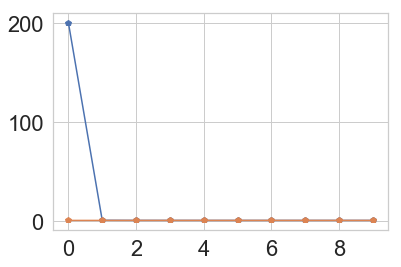

In [287]:
plt.plot(model.history.history['loss'],'-p')
plt.plot(model.history.history['val_loss'],'-p')


In [288]:
model.predict(train_x_).ravel()

array([0.01156774, 0.01156774, 0.01156774, ..., 0.01156774, 0.01156774,
       0.01156774], dtype=float32)

In [290]:
del train_1, valid_1, train_test_X, train_x_, valid_x_, embedding_matrix
del new_df, w2v_model, tokenizer
gc.collect()

0

In [11]:
import h2o
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpk4b_xv35
  JVM stdout: /tmp/tmpk4b_xv35/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmpk4b_xv35/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 1 month and 28 days !!!"
H2O cluster name:,H2O_from_python_ankish_bz2ak0
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [35]:
# train1 = train_.astype('object')
# valid1 = valid_.astype('object')


In [38]:
train = h2o.H2OFrame(pd.concat([train1, y_tr], axis=1))                     
test  = h2o.H2OFrame(pd.concat([valid1, y_val], axis=1))                     

print(train.shape, test.shape)

x = list(train_.columns)
y = "amount_spent_per_room_night_scaled"

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(256068, 58) (85356, 58)


0

In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [30]:
gbm_params = {
#     'nfolds'              :  3,
#     'ignored_columns'     : drop_cols,
    'ntrees'              : 200,
    'max_depth'           : 4,# (default=20)
    'min_rows'            : None, # Specify the minimum number of observations for a leaf
    'nbins'               :  63, # Specify the number of bins for the histogram to build, then split at the best point.
#     'nbins_cats'          : None # (Extensively tuning needed)
#     'verbose'             : True,
    'seed'                : 1234,
    'learn_rate'          : 0.01,
#     'learn_rate_annealing': 0.99, # (danger as it reduce the lr_rate rapidly) (for lr:0.01, use lr:0.05, with anealing of 0.99, lead to better converger (fast))
    'distribution'        :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
    'sample_rate'         : 0.7, # default 0.63 (samples without replacement)
#     'sample_rate_per_class':0.7, # sample from the full dataset using a per-class-specific sampling rate rather than a global sample factor
    'col_sample_rate'     : 0.7, # sampling without replacement
#     'col_sample_rate_per_tree':0.7, # sample without replacement.
    'histogram_type'      : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#     'fold_column'         : None, # col name for cv fold
#     'weights_column'      : col_name, # which should be present in the dataframe as an indiaction to weights of each row.
#     'fold_assignment'     : 'Random', # (used only is fold_column is not specified) [Random, Modulo, Stratified]
#     'balance_classes'     : True, # only for classification (balance the classes by oversampling),

    'min_split_improvement' : 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'categorical_encoding'  : 'eigen', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
#     'keep_cross_validation_predictions':True,
    'score_each_iteration'  : True, # scoring at each iteration
    'score_tree_interval'   : 5, # score after each 5 tree built
    'stopping_rounds'       : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'       : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'    : 0.001, # tolerance factor for wait till stopping
#     'max_after_balance_size': 1,# (0-inf) for oversampling choose > 1, else < 1.
#     'class_sampling_factors': 1, # ration of over/under-sampling rate. By default, these ratios are automatically computed during training to obtain the class balance. Note that this requires balance_classes=true.
#     'quantile_alpha'        : 0.01, # when distribution is quantile. (Specify the quantile to be used for Quantile Regression.)
#     'huber_alpha'           : 0.001, # Huber/M-regression (the threshold between quadratic and linear loss)
#     'max_abs_leafnode_pred' : None, # (only for clf), it reduce overfitting by limiting the maximum absolute value of a leaf node prediction
#     'pred_noise_bandwidth'  : 0 # The bandwidth (sigma) of Gaussian multiplicative noise ~N(1,sigma) for tree node predictions. If this parameter is specified with a value greater than 0, then every leaf node prediction is randomly scaled by a number drawn from a Normal distribution centered around 1 with a bandwidth given by this parameter
#     'nbins_top_level'       : None # Specify the minimum number of bins at the root level to use to build the histogram. This number will then be decreased by a factor of two per level.
}

In [31]:
x = list(train.columns)
y = "amount_spent_per_room_night_scaled"
x.remove(y)

gbm_model = H2OGradientBoostingEstimator(**gbm_params)
gbm_model.train(x, y, training_frame=train, validation_frame=test)
gbm_model.rmse()

gbm Model Build progress: |███████████████████████████████████████████████| 100%


1.009754306062416

In [22]:
# gbm_model.hit_ratio_table(valid=True)

1.0097543060623764

In [ ]:
drf_model_deep = H2ORandomForestEstimator( 
nfolds=3, seed=1234,
keep_cross_validation_predictions=True,
fold_assignment = 'stratified',
histogram_type = 'QuantilesGlobal',
categorical_encoding = 'eigen',
stopping_metric = 'auc',
ntrees = 100,
balance_classes = True
)

def get_drf_details():
    """
    'nfolds': 3,
    'keep_cross_validation_predictions':True,
    'score_each_iteration' : True, # scoring at each iteration
    'score_tree_interval'  : 5, # score after each 5 tree built
    'fold_assignment'      : 'Random', # (used only is fold_column is not specified) [Random, Modulo, Stratified]
    'fold_column'          : None, # col name for cv fold
    'ignored_columns'      : drop_cols,
    'balance_classes'      : True, # only for classification (balance the classes by oversampling),
    'max_after_balance_size':1,# (0-inf) for oversampling choose > 1, else < 1.
    'ntrees'               : 200,
    'max_depth'            : 10,# (default=20)
    'min_rows'             : None, # Specify the minimum number of observations for a leaf
    'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
    'nbins_top_level'      : None # Specify the minimum number of bins at the root level to use to build the histogram. This number will then be decreased by a factor of two per level.
    # 'nbins_cats': # (Extensively tuning needed)
    'stopping_rounds'      : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'      : 'auc', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'   : 0.001, # tolerance factor for wait till stopping
    'seed'                 : 1234,
    'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
    'verbose'              : 25,
    'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
    'col_sample_rate_per_tree':0.7, # sample without replacement.
    'min_split_improvement': 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'sample_rate'          : 0.7, # default 0.63 (samples without replacement)
    'sample_rate_per_class': 0.7, # sample from the full dataset using a per-class-specific sampling rate rather than a global sample factor
    'binomial_double_trees': True, # (Binary classification only) Build twice as many trees (one per class). Enabling this option can lead to higher accuracy, while disabling can result in faster model building.
    'mtries'               : -1, # Specify the columns to randomly select at each level. If the default value of -1 is used, the number of variables is the square root of the number of columns for classification and p/3 for regression (where p is the number of predictors). The range is -1 to >=1.
    'class_sampling_factors':1, # ration of over/under-sampling rate. By default, these ratios are automatically computed during training to obtain the class balance. Note that this requires balance_classes=true.
    'weights_column':col_name, # which should be present in the dataframe as an indiaction to weights of each row.
    """
    pass

In [ ]:
gbm_params = {
    'max_depth'           : 4,# (default=20)
    'min_rows'            : None, # Specify the minimum number of observations for a leaf
    'sample_rate'         : 0.7, # default 0.63 (samples without replacement)
    'col_sample_rate'     : 0.7, # sampling without replacement
    
    'ntrees'              : 200,
    'nbins'               :  63, # Specify the number of bins for the histogram to build, then split at the best point.
    'seed'                : 1234,
    'learn_rate'          : 0.01,
    'distribution'        :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
    'histogram_type'      : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
    'min_split_improvement' : 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'categorical_encoding'  : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
    'score_each_iteration'  : True, # scoring at each iteration
    'score_tree_interval'   : 5, # score after each 5 tree built
    'stopping_rounds'       : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'       : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'    : 0.001, # tolerance factor for wait till stopping
}

In [69]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
            'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [65]:
h2o.no_progress()

In [70]:
bo_tuning_gbm = bayesian_opt_gbm(train, test)


|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.078    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.074    |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.069    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.075    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.078    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.072    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.067    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.068    |  0.495    |  12.07    |  2.141    |  9.862e-0 |  0.7189   |
|  9        | -1.08     |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.082    |  0.693    |  3.421    |  5.8

In [71]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [72]:
bo_tuning_drf = bayesian_opt_drf(train, test)


|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.016    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.01     |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.012    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.008    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.021    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.008    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.017    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.021    |  0.495    |  12.07    |  2.141    |  9.871e-0 |  0.7189   |
|  9        | -1.024    |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.051    |  0.693    |  3.421    |  5.8

In [73]:
bo_tuning_gbm.max, bo_tuning_drf.max

({'target': -1.0599026936288272,
  'params': {'col_sample': 0.7242822312930688,
   'depth': 14.993440885191694,
   'min_rows': 1.6443264205577606,
   'min_split': 0.0008642254019696913,
   'sample': 0.7990592980041672}},
 {'target': -1.0019219750991446,
  'params': {'col_sample': 0.774610595517792,
   'depth': 11.779096559106708,
   'min_rows': 8.07895045786083,
   'min_split': 0.0009420702334867748,
   'sample': 0.30006254152724415}})

In [ ]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
            'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'sort_by_response', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [ ]:
# try:
#     bo_tuning_gbm2 = bayesian_opt_gbm(train, test)
# except:
#     print("failed")
bo_tuning_gbm2 = bayesian_opt_gbm(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.078    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.074    |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.069    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.075    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.078    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.072    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.067    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.068    |  0.495    |  12.07    |  2.141    |  9.862e-0 |  0.7189   |
|  9        | -1.08     |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.082    |  0.693    |  3.421    |  5.8

In [ ]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'sort_by_response', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [ ]:
# try:
#     bo_tuning_drf2 = bayesian_opt_drf(train, test)
# except:
#     print("failed")
bo_tuning_drf2 = bayesian_opt_drf(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.016    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.01     |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.012    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.008    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.021    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.008    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.017    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.021    |  0.495    |  12.07    |  2.141    |  9.871e-0 |  0.7189   |
|  9        | -1.024    |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.051    |  0.693    |  3.421    |  5.8

In [ ]:
bo_tuning_gbm2.max, bo_tuning_drf2.max

({'target': -1.0599026936288272,
  'params': {'col_sample': 0.7242822312930688,
   'depth': 14.993440885191694,
   'min_rows': 1.6443264205577606,
   'min_split': 0.0008642254019696913,
   'sample': 0.7990592980041672}},
 {'target': -1.0019219750991446,
  'params': {'col_sample': 0.774610595517792,
   'depth': 11.779096559106708,
   'min_rows': 8.07895045786083,
   'min_split': 0.0009420702334867748,
   'sample': 0.30006254152724415}})

In [ ]:
h2o.shutdown(prompt=False)

[WARNING] in <ipython-input-79-02ff3806b010> line 1:
    >>> h2o.shutdown(prompt=False)
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_934b closed.


In [ ]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_cat(X_train, y_train, X_valid, y_valid, features):
        
    def train_cat_model(r_str, b_temp, l2, depth):
    
        params = {}

        params['random_strength']     = max(min(r_str, 1), 0)
        params['bagging_temperature'] = max(b_temp, 0)
        
        params['l2_leaf_reg'] = max(l2, 0)
#         params['min_data_in_leaf'] = max(data_leaf,1)
        
#         params['subsample'] = subsample
        params['depth']     = int(depth)

        param_const = {
            'border_count'          : 63,
            'early_stopping_rounds' : 50,
            'random_seed'           : 1337,
            'task_type'             : 'CPU', 
            'loss_function'         : "RMSE", 
    #         'subsample'             = 0.7, 
            'iterations'            : 10000, 
            'learning_rate'         : 0.01,
            'thread_count'          : 4,
#             'bootstrap_type'        : 'No'
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

        watchlist = [_train, _valid]
        clf = CatBoostRegressor(**params)
        clf.fit(_train, 
                eval_set=watchlist, 
                verbose=0,
                use_best_model=True)

        oof  = clf.predict(X_valid[features])

        score = mean_squared_error(y_valid, oof)

        return -score

    _bo = BayesianOptimization(train_cat_model, {

        'r_str'      : (1, 5),
        'b_temp'     : (0.01, 100),
        'depth'      : (3,8), # int
#         'subsample'  : (0.3, 0.8),
#         'data_leaf'  : (2,7),
        'l2'         : (0, 5),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=35, acq='ei')
    
    return _bo



In [ ]:
bo_tuning_cat = bayesian_opt_cat(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_temp   |   depth   |    l2     |   r_str   |
-------------------------------------------------------------------------
|  1        | -0.9559   |  32.19    |  4.637    |  4.637    |  2.247    |
|  2        | -0.9538   |  16.2     |  4.82     |  2.646    |  4.156    |
|  3        | -1.183    |  87.54    |  6.183    |  4.949    |  4.264    |
|  4        | -0.9494   |  4.141    |  4.015    |  0.762    |  4.012    |
|  5        | -1.183    |  45.52    |  7.773    |  4.687    |  1.542    |
|  6        | -0.9549   |  23.6     |  4.574    |  3.363    |  3.482    |
|  7        | -1.183    |  62.22    |  7.189    |  3.154    |  3.244    |
|  8        | -1.183    |  98.69    |  6.416    |  0.5066   |  4.76     |
|  9        | -1.183    |  65.14    |  4.137    |  2.159    |  2.56     |
|  10       | -1.183    |  75.58    |  3.713    |  0.04931  |  4.352    |
|  11       | -0.9532   |  10.89    |  4.246    |  2.379    |  4.536    |
|  12       | -0.9463   |  17.76    | 

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)

        return -score


    _bo = BayesianOptimization(train_lgb_model, {
 
        'b_frac'       : (0.35, 0.7),
        'f_frac'       : (0.35, 0.8),
        'leaves'       : (40,90), # int
        'split_gain'   : (0, 2),
        'l1'           : (0, 3),
        'l2'           : (0, 3),
        'data_in_leaf' : (20, 1000), # int
        'hessian'      : (0, 20),


    }, random_state=23456)
    _bo.maximize(init_points=40, n_iter=35, acq='ei')
    
    return _bo



In [ ]:
bo_tuning_lgb = bayesian_opt_lgb(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_frac   | data_i... |  f_frac   |  hessian  |    l1     |    l2     |  leaves   | split_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.9387   |  0.4626   |  340.8    |  0.7673   |  6.234    |  0.4859   |  1.092    |  66.46    |  1.578    |
|  2        | -0.9386   |  0.6564   |  643.9    |  0.7954   |  16.32    |  0.1239   |  0.6088   |  47.62    |  1.506    |
|  3        | -0.9384   |  0.5093   |  955.5    |  0.7718   |  2.708    |  0.7077   |  0.9445   |  73.63    |  1.241    |
|  4        | -0.9393   |  0.5677   |  841.1    |  0.6339   |  11.22    |  2.961    |  2.049    |  45.07    |  1.88     |
|  5        | -0.9387   |  0.578    |  242.9    |  0.5443   |  7.802    |  2.267    |  0.4279   |  40.49    |  1.676    |
|  6        | -0.9377   |  0.3881   |  264.2    |  0.5642   |  17.68    |  0.5325   |  2.358    |  41.75    |  1.217    |
|  7        | -0.9368   

In [ ]:
{'target': -0.9362267064104927,
 'params': {'b_frac': 0.3677516358370858,
  'data_in_leaf': 495.44417416221626,
  'f_frac': 0.5422060360159515,
  'hessian': 5.039378213231793,
  'l1': 1.0642598045225304,
  'l2': 2.564544963055539,
  'leaves': 89.62655396835916,
  'split_gain': 0.16542750189034394}}

bo_tuning_cat.max

{'target': -0.9366723276780314,
 'params': {'b_temp': 0.08307474720468191,
  'depth': 7.596402546589758,
  'l2': 3.9791105400066655,
  'r_str': 1.1206250787323229}}

In [ ]:
gc.collect()

In [ ]:

import h2o
h2o.init()

train = h2o.H2OFrame(pd.concat([train1, y_tr], axis=1))                     
test  = h2o.H2OFrame(pd.concat([valid1, y_val], axis=1))                     

print(train.shape, test.shape)

x = list(train_.columns)
y = "amount_spent_per_room_night_scaled"

gc.collect()

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator


In [ ]:
bo_tuning_cat.max, bo_tuning_lgb.max

In [ ]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
#             'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'one_hot_explicit', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [ ]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'one_hot_explicit', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [ ]:
bo_tuning_gbm3 = bayesian_opt_gbm(train, test)

In [ ]:
bo_tuning_gbm3.max

In [ ]:
bo_tuning_drf3 = bayesian_opt_drf(train, test)

In [ ]:
bo_tuning_drf3.max

In [49]:

import pandas as pd
import numpy as np
import os, gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_squared_error
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb


def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, lgb_imp
    



def run_cv_lgb(train_df, target, test_df, leaves=None):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'rmse',
        'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'root_mean_squared_error',
        'verbosity'              : 1,
    #     'lambda_l1'              : 0.001,
        'lambda_l2'              : 0.1
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 3
    num_round = 10000
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
#         X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#         X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)

        num_round = 10000
        oof, test_pred, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, param, 
                                                       test_df, num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  rmse = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_lgb, predictions




In [71]:
import copy

train_df1 = copy.deepcopy(train_df)
test_df1 = copy.deepcopy(test_df)


In [72]:
train_df1.drop(['reservation_id', 'memberid'], axis=1, inplace=True)
test_df1.drop(['reservation_id', 'memberid'], axis=1, inplace=True)

target = train_df.amount_spent_per_room_night_scaled
train_df1.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)

train_df1 = train_df1.astype('object')
test_df1  = test_df1.astype('object')


In [73]:
complete_df = pd.concat([train_df1, test_df1], axis=0).reset_index(drop=True)

for col in complete_df.columns:
    complete_df[col] = complete_df[col].astype('category').cat.codes
    
del train_df1, test_df1
gc.collect()

train_df1 = complete_df.iloc[:train_df.shape[0]]
test_df1  = complete_df.iloc[train_df.shape[0]:]

gc.collect()

0

In [74]:
clfs_lgb, imp_lgb, oof_lgb, pred_lgb = run_cv_lgb(train_df1, target, 
                                                  test_df1, leaves=50)


using leaves:  50
(227616,) (113808,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 1.46449	valid_1's rmse: 1.46804
[400]	training's rmse: 1.03143	valid_1's rmse: 1.0345
[600]	training's rmse: 1.0144	valid_1's rmse: 1.01885
[800]	training's rmse: 1.00885	valid_1's rmse: 1.01489
[1000]	training's rmse: 1.00497	valid_1's rmse: 1.01259
[1200]	training's rmse: 1.00098	valid_1's rmse: 1.01027
[1400]	training's rmse: 0.9973	valid_1's rmse: 1.00813
[1600]	training's rmse: 0.992678	valid_1's rmse: 1.00504
[1800]	training's rmse: 0.990019	valid_1's rmse: 1.0038
[2000]	training's rmse: 0.986463	valid_1's rmse: 1.00165
[2200]	training's rmse: 0.984166	valid_1's rmse: 1.00078
[2400]	training's rmse: 0.981085	valid_1's rmse: 0.99911
[2600]	training's rmse: 0.978644	valid_1's rmse: 0.998053
[2800]	training's rmse: 0.97589	valid_1's rmse: 0.996625
[3000]	training's rmse: 0.973695	valid_1's rmse: 0.995726
[3200]	training's rmse: 0.9711	valid_1's rmse: 0.99

In [65]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostRegressor(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict(X_valid[features])
    test_pred  = clf.predict(X_test[features])

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "RMSE", 
#         'eval_metric'           : "AUC",
        'random_strength'       : 1.5,
        'border_count'          : 128,
#         'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.09,
        'thread_count'          : 4
    }


    ##########################
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  auc = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions



In [75]:
clfs_cat, imp_cat, oof_cat, pred_cat = run_cv_cat(train_df1, target, test_df1, 4)


(227616,) (113808,)
Fold 0
0:	learn: 7.1087168	test: 7.1087168	test1: 7.1130523	best: 7.1130523 (0)	total: 20.8ms	remaining: 3m 27s
200:	learn: 1.0182283	test: 1.0182283	test1: 1.0183900	best: 1.0183900 (200)	total: 6.07s	remaining: 4m 56s
400:	learn: 1.0051033	test: 1.0051033	test1: 1.0070166	best: 1.0070166 (400)	total: 12.1s	remaining: 4m 49s
600:	learn: 0.9972679	test: 0.9972679	test1: 1.0008241	best: 1.0008216 (599)	total: 18s	remaining: 4m 41s
800:	learn: 0.9920203	test: 0.9920203	test1: 0.9968622	best: 0.9968622 (800)	total: 23.8s	remaining: 4m 33s
1000:	learn: 0.9881551	test: 0.9881551	test1: 0.9941965	best: 0.9941965 (1000)	total: 29.6s	remaining: 4m 26s
1200:	learn: 0.9847933	test: 0.9847933	test1: 0.9921452	best: 0.9921452 (1200)	total: 35.5s	remaining: 4m 20s
1400:	learn: 0.9824931	test: 0.9824931	test1: 0.9911621	best: 0.9911561 (1399)	total: 41.4s	remaining: 4m 14s
1600:	learn: 0.9803233	test: 0.9803233	test1: 0.9900051	best: 0.9900044 (1599)	total: 47.2s	remaining: 4m 7s

In [85]:

def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'rmse',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
#         'Scale_pos_weight': 3.607,
#         'objective'       : 'reg:squarederror',
        'max_depth'       : depth,
        'alpha'           : 0.05
    }
    
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  auc = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb, predictions


In [89]:
clfs_xgb, imp_xgb, oof_xgb, pred_xgb = run_cv_xgb(train_df1, target, test_df1, 4)


(227616,) (113808,)
Fold 0
[0]	valid-rmse:6.94846
Will train until valid-rmse hasn't improved in 25 rounds.
[200]	valid-rmse:1.02016
[400]	valid-rmse:1.01442
[600]	valid-rmse:1.01005
[800]	valid-rmse:1.00453
[1000]	valid-rmse:0.999952
[1200]	valid-rmse:0.996541
[1400]	valid-rmse:0.994686
[1600]	valid-rmse:0.992758
[1800]	valid-rmse:0.991263
[2000]	valid-rmse:0.990132
[2200]	valid-rmse:0.989238
[2400]	valid-rmse:0.988517
[2600]	valid-rmse:0.987852
Stopping. Best iteration:
[2596]	valid-rmse:0.987844

  auc =  98.78438239224694
(227616,) (113808,)
Fold 1
[0]	valid-rmse:6.94318
Will train until valid-rmse hasn't improved in 25 rounds.
[200]	valid-rmse:1.02129
[400]	valid-rmse:1.01675
[600]	valid-rmse:1.01156
[800]	valid-rmse:1.00631
[1000]	valid-rmse:1.00209
[1200]	valid-rmse:0.998696
[1400]	valid-rmse:0.9965
[1600]	valid-rmse:0.994389
[1800]	valid-rmse:0.99262
[2000]	valid-rmse:0.991479
[2200]	valid-rmse:0.990637
[2400]	valid-rmse:0.989865
Stopping. Best iteration:
[2461]	valid-rmse:0.98

In [ ]:
sns.pairplot(train_df1)